# 서울시 요식업 평균 매출 예측 모델

서울시 요식업 매출 데이터를 분석하고 예측 모델을 구축하여 창업 의사결정에 도움이 될 수 있는 인사이트를 제공합니다.

## 1. 데이터 로딩과 전처리

### 1.1 필요한 라이브러리 임포트 및 환경 설정

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc, joblib
from pathlib import Path

# 한글 폰트 설정
plt.rc("font", family="NanumGothic")
plt.rcParams["axes.unicode_minus"] = False

# 머신러닝 관련 라이브러리 임포트
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# 결과 저장용 디렉토리 생성
Path("plots").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)

### 1.2 데이터 로드

In [2]:
# 원본 데이터 로드
sales_df = pd.read_csv("data/서울시 상권분석서비스(추정매출-상권).csv", encoding="cp949")
work_df = pd.read_csv("data/서울시 상권분석서비스(직장인구-상권).csv", encoding="cp949")
street_df = pd.read_csv("data/서울시 상권분석서비스(길단위인구-상권).csv", encoding="cp949")

### 1.3 데이터 기본 정보 확인

In [3]:
# 데이터셋 기본 정보 출력
print("=== 데이터셋 기본 정보 ===")
print(f"매출 데이터: {sales_df.shape[0]}행, {sales_df.shape[1]}열")
print(f"직장인구 데이터: {work_df.shape[0]}행, {work_df.shape[1]}열")
print(f"유동인구 데이터: {street_df.shape[0]}행, {street_df.shape[1]}열")

=== 데이터셋 기본 정보 ===
매출 데이터: 87179행, 55열
직장인구 데이터: 6549행, 26열
유동인구 데이터: 6595행, 27열


### 1.4 매출 데이터 샘플 및 컬럼 확인

In [4]:
# 데이터 샘플 확인
print("=== 매출 데이터 샘플 ===")
print(sales_df.head(2))

# 데이터 컬럼 확인
print("\n=== 매출 데이터 컬럼 목록 ===")
print(sales_df.columns.tolist())

=== 매출 데이터 샘플 ===
   기준_년분기_코드 상권_구분_코드 상권_구분_코드_명    상권_코드   상권_코드_명 서비스_업종_코드 서비스_업종_코드_명  \
0      20241        U       관광특구  3001491  이태원 관광특구  CS100001       한식음식점   
1      20241        U       관광특구  3001491  이태원 관광특구  CS100002       중식음식점   

       당월_매출_금액  당월_매출_건수      주중_매출_금액  ...  시간대_건수~21_매출_건수  \
0  1.185751e+10    254192  6.640829e+09  ...            69016   
1  1.911647e+09     46140  1.259317e+09  ...            18085   

   시간대_건수~24_매출_건수  남성_매출_건수  여성_매출_건수  연령대_10_매출_건수  연령대_20_매출_건수  \
0            38472    129419    109336          1277         73116   
1             4918     21479     21646           151         14443   

   연령대_30_매출_건수  연령대_40_매출_건수  연령대_50_매출_건수  연령대_60_이상_매출_건수  
0         86124         33511         28074            16652  
1         15206          5918          4892             2514  

[2 rows x 55 columns]

=== 매출 데이터 컬럼 목록 ===
['기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '당월_매출_금액', '당월_매출_건수

### 1.5 결측치 및 요식업 코드 분포 확인

In [5]:
# 결측치 확인
print("=== 결측치 확인 ===")
missing_sales = sales_df.isnull().sum()
missing_sales = missing_sales[missing_sales > 0]
if len(missing_sales) > 0:
    print("매출 데이터 결측치: ")
    print(missing_sales)
else:
    print("매출 데이터에 결측치가 없습니다.")

# 요식업 코드 및 유형 확인
print("\n=== 요식업 서비스 코드 분포 ===")
cs_codes = sales_df["서비스_업종_코드"].str.startswith("CS1").value_counts()
print(f"CS로 시작하는 코드 수: {cs_codes.get(True, 0)}/{len(sales_df)}")

=== 결측치 확인 ===
매출 데이터에 결측치가 없습니다.

=== 요식업 서비스 코드 분포 ===
CS로 시작하는 코드 수: 27095/87179


### 1.6 요식업 데이터 필터링

In [6]:
# 요식업 데이터만 필터링 (CS1 코드)
restaurant_sales = sales_df[sales_df["서비스_업종_코드"].str.startswith("CS1")].copy()
print(f"요식업(CS1) 데이터 추출: {len(restaurant_sales)}행")

# 요식업 코드 분포 확인
if '서비스_업종_코드_명' in restaurant_sales.columns:
    print("\n=== 요식업 유형 분포 ===")
    print(restaurant_sales['서비스_업종_코드_명'].value_counts())

요식업(CS1) 데이터 추출: 27095행

=== 요식업 유형 분포 ===
서비스_업종_코드_명
한식음식점      5645
커피-음료      4348
호프-간이주점    3641
분식전문점      3224
치킨전문점      2196
중식음식점      1839
제과점        1719
패스트푸드점     1718
일식음식점      1396
양식음식점      1369
Name: count, dtype: int64


In [ ]:
restaurant_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27095 entries, 0 to 87165
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        27095 non-null  int64  
 1   상권_구분_코드         27095 non-null  object 
 2   상권_구분_코드_명       27095 non-null  object 
 3   상권_코드            27095 non-null  int64  
 4   상권_코드_명          27095 non-null  object 
 5   서비스_업종_코드        27095 non-null  object 
 6   서비스_업종_코드_명      27095 non-null  object 
 7   당월_매출_금액         27095 non-null  float64
 8   당월_매출_건수         27095 non-null  int64  
 9   주중_매출_금액         27095 non-null  float64
 10  주말_매출_금액         27095 non-null  float64
 11  월요일_매출_금액        27095 non-null  float64
 12  화요일_매출_금액        27095 non-null  float64
 13  수요일_매출_금액        27095 non-null  float64
 14  목요일_매출_금액        27095 non-null  float64
 15  금요일_매출_금액        27095 non-null  float64
 16  토요일_매출_금액        27095 non-null  float64
 17  일요일_매출_금액        

### 1.9 평균 매출 계산

In [10]:
# 평균매출 계산
grouped = restaurant_sales.groupby(["상권_코드_명", "기준_년분기_코드"])[["당월_매출_금액"]].mean().reset_index()
grouped.rename(columns={"당월_매출_금액": "평균매출"}, inplace=True)

# 평균매출 분포 확인
print("\n=== 평균매출 기본 통계량 ===")
print(grouped["평균매출"].describe())


=== 평균매출 기본 통계량 ===
count    5.915000e+03
mean     6.709910e+08
std      1.154353e+09
min      1.424950e+05
25%      1.727753e+08
50%      3.506407e+08
75%      6.727847e+08
max      1.964679e+10
Name: 평균매출, dtype: float64


### 1.10 매출 분포 시각화

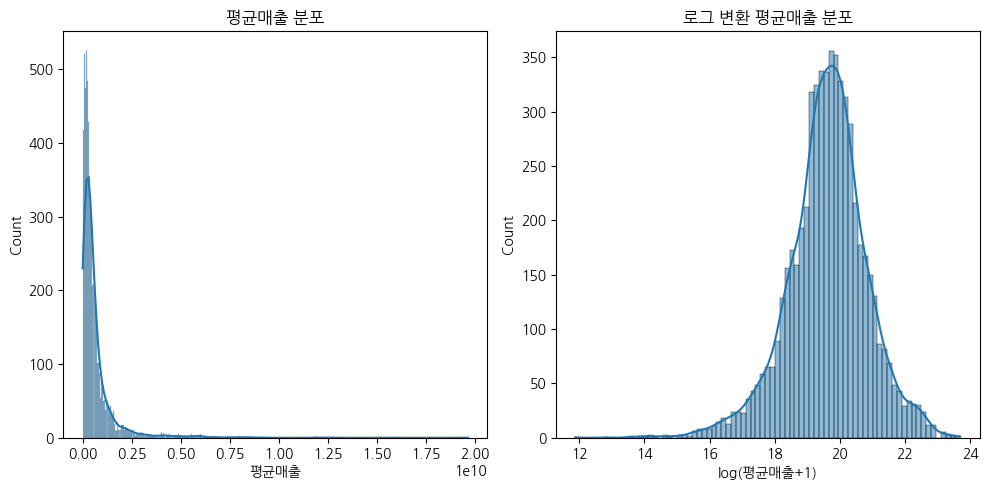

In [11]:
# 매출 분포 히스토그램
plt.figure(figsize=(10, 5))

# 원본 매출 분포
plt.subplot(1, 2, 1)
sns.histplot(grouped["평균매출"], kde=True)
plt.title("평균매출 분포")
plt.xlabel("평균매출")

# 로그 변환 매출 분포 (왜도 확인)
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(grouped["평균매출"]), kde=True)
plt.title("로그 변환 평균매출 분포")
plt.xlabel("log(평균매출+1)")

plt.tight_layout()
plt.show()

### 1.11 데이터 병합

In [13]:
# 데이터 병합
merged = pd.merge(grouped, street_df, on=["상권_코드_명", "기준_년분기_코드"], how="left")
merged = pd.merge(merged, work_df, on=["상권_코드_명", "기준_년분기_코드"], how="left")

# 병합 결과 확인
print("=== 병합 결과 확인 ===")
print(f"원본 평균매출 데이터: {grouped.shape[0]}행, {grouped.shape[1]}열")
print(f"\n병합 후 데이터: {merged.shape[0]}행, {merged.shape[1]}열")

# 병합 후 결측치 확인
missing_after_merge = merged.isnull().sum().sum()
missing_percent = (missing_after_merge / (merged.shape[0] * merged.shape[1])) * 100
print(f"병합 후 총 결측치: {missing_after_merge}개 ({missing_percent:.2f}%)")

=== 병합 결과 확인 ===
원본 평균매출 데이터: 5915행, 3열

병합 후 데이터: 5915행, 52열
병합 후 총 결측치: 653개 (0.21%)


### 1.12 병합 결과 샘플 확인

In [14]:
# 병합 결과 샘플 확인
print("\n=== 병합 결과 샘플 ===")
# 병합된 데이터의 주요 컬럼 샘플 출력
sample_cols = ['상권_코드_명', '기준_년분기_코드', '평균매출']
if '총_유동인구_수' in merged.columns:
    sample_cols.append('총_유동인구_수')
if '총_직장_인구_수' in merged.columns:
    sample_cols.append('총_직장_인구_수')
print(merged[sample_cols].head(3))


=== 병합 결과 샘플 ===
        상권_코드_명  기준_년분기_코드         평균매출   총_유동인구_수  총_직장_인구_수
0  4.19민주묘지역 2번      20241  579173781.5  1021175.0      164.0
1  4.19민주묘지역 2번      20242  647617846.2  1065757.0      164.0
2  4.19민주묘지역 2번      20243  578556573.8   981924.0      164.0


### 1.13 상권 구분 코드 병합 및 결측치 처리

In [15]:
# 상권 구분 코드 병합
duplicate_drop = sales_df[["상권_코드_명", "상권_구분_코드_명"]].drop_duplicates()
restaurant_data = pd.merge(merged, duplicate_drop, on="상권_코드_명", how="left")

# 결측치 처리
# 수치형 컬럼 - 중앙값으로 대체
numeric_cols = restaurant_data.select_dtypes(include=['number']).columns
for col in numeric_cols:
    if restaurant_data[col].isnull().any():
        restaurant_data[col] = restaurant_data[col].fillna(restaurant_data[col].median())

# 문자열 컬럼 - 최빈값으로 대체
object_cols = restaurant_data.select_dtypes(include=['object']).columns
for col in object_cols:
    if restaurant_data[col].isnull().any():
        restaurant_data[col] = restaurant_data[col].fillna(restaurant_data[col].mode().iloc[0] if not restaurant_data[col].mode().empty else "알수없음")

## 2. 특성 엔지니어링

### 2.0 특성 정의

In [16]:
# 수치형 변수와 범주형 변수 정의 - 시각화와 모델링에 일관되게 사용
numeric_features = [
    "총_유동인구_수", "남성_유동인구_수", "여성_유동인구_수", 
    "총_직장_인구_수", "남성_직장_인구_수", "여성_직장_인구_수", 
    "초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수", 
    "초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수"
]

categorical_features = ["상권_구분_코드_명", "기준_년분기_코드"]

### 2.1 연령대별 인구 통합 특성 생성

In [17]:
# 연령대별 인구 통합 
restaurant_data["초년_유동인구_수"] = restaurant_data["연령대_10_유동인구_수"] + restaurant_data["연령대_20_유동인구_수"]
restaurant_data["중년_유동인구_수"] = restaurant_data["연령대_30_유동인구_수"] + restaurant_data["연령대_40_유동인구_수"]
restaurant_data["노년_유동인구_수"] = restaurant_data["연령대_50_유동인구_수"] + restaurant_data["연령대_60_이상_유동인구_수"]
restaurant_data["초년_직장_인구_수"] = restaurant_data["연령대_10_직장_인구_수"] + restaurant_data["연령대_20_직장_인구_수"]
restaurant_data["중년_직장_인구_수"] = restaurant_data["연령대_30_직장_인구_수"] + restaurant_data["연령대_40_직장_인구_수"]
restaurant_data["노년_직장_인구_수"] = restaurant_data["연령대_50_직장_인구_수"] + restaurant_data["연령대_60_이상_직장_인구_수"]

### 2.2 성별 인구 분포 및 영향 분석

In [18]:
# 성별 유동인구 비율 계산
restaurant_data['남성_유동인구_비율'] = restaurant_data['남성_유동인구_수'] / restaurant_data['총_유동인구_수']
restaurant_data['여성_유동인구_비율'] = restaurant_data['여성_유동인구_수'] / restaurant_data['총_유동인구_수']
restaurant_data['남성_직장인구_비율'] = restaurant_data['남성_직장_인구_수'] / restaurant_data['총_직장_인구_수']
restaurant_data['여성_직장인구_비율'] = restaurant_data['여성_직장_인구_수'] / restaurant_data['총_직장_인구_수']

# 결측치 처리 (0으로 나누는 경우)
for col in ['남성_유동인구_비율', '여성_유동인구_비율', '남성_직장인구_비율', '여성_직장인구_비율']:
    restaurant_data[col] = restaurant_data[col].fillna(0)

### 2.3 성별 분포 시각화

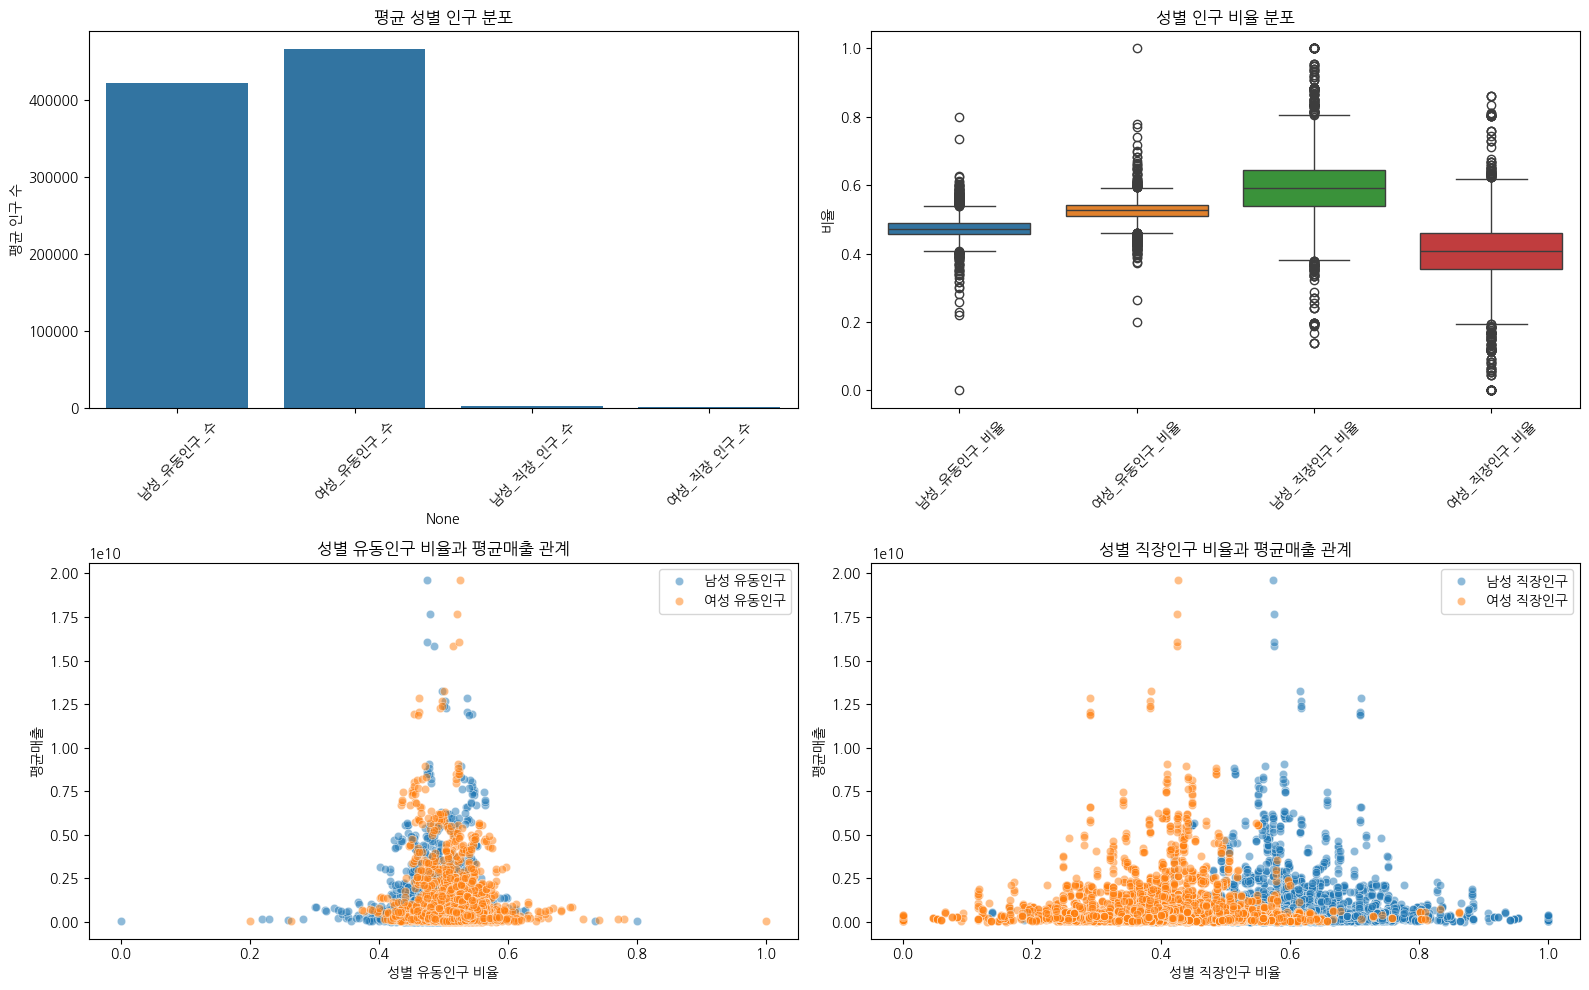

In [19]:
# 성별 인구 분포 시각화
plt.figure(figsize=(16, 10))

# 1. 유동인구와 직장인구의 성별 분포 (절대값)
plt.subplot(2, 2, 1)
gender_data = restaurant_data[['남성_유동인구_수', '여성_유동인구_수', '남성_직장_인구_수', '여성_직장_인구_수']].mean()
sns.barplot(x=gender_data.index, y=gender_data.values)
plt.title('평균 성별 인구 분포')
plt.ylabel('평균 인구 수')
plt.xticks(rotation=45)

# 2. 유동인구와 직장인구의 성별 비율 분포 (상자 그림)
plt.subplot(2, 2, 2)
gender_ratio = restaurant_data[['남성_유동인구_비율', '여성_유동인구_비율', '남성_직장인구_비율', '여성_직장인구_비율']]
sns.boxplot(data=gender_ratio)
plt.title('성별 인구 비율 분포')
plt.ylabel('비율')
plt.xticks(rotation=45)

# 3. 성별 인구 비율과 평균매출 관계 (산점도)
plt.subplot(2, 2, 3)
sns.scatterplot(x='남성_유동인구_비율', y='평균매출', data=restaurant_data, alpha=0.5, label='남성 유동인구')
sns.scatterplot(x='여성_유동인구_비율', y='평균매출', data=restaurant_data, alpha=0.5, label='여성 유동인구')
plt.title('성별 유동인구 비율과 평균매출 관계')
plt.xlabel('성별 유동인구 비율')
plt.ylabel('평균매출')
plt.legend()

# 4. 성별 직장인구 비율과 평균매출 관계 (산점도)
plt.subplot(2, 2, 4)
sns.scatterplot(x='남성_직장인구_비율', y='평균매출', data=restaurant_data, alpha=0.5, label='남성 직장인구')
sns.scatterplot(x='여성_직장인구_비율', y='평균매출', data=restaurant_data, alpha=0.5, label='여성 직장인구')
plt.title('성별 직장인구 비율과 평균매출 관계')
plt.xlabel('성별 직장인구 비율')
plt.ylabel('평균매출')
plt.legend()

plt.tight_layout()
plt.show()

### 2.4 상권 및 시간 카테고리 분석

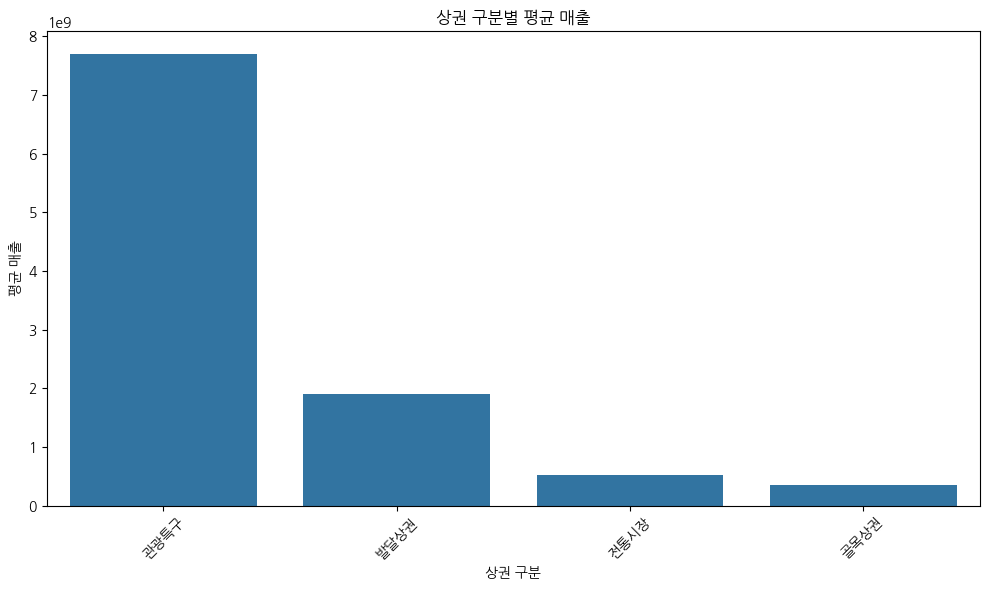

In [20]:
# 범주형 변수 분석 (상권_구분_코드_명, 기준_년분기_코드)
plt.figure(figsize=(10, 6))

# 상권 구분별 평균 매출
sns.barplot(x='상권_구분_코드_명', y='평균매출', data=restaurant_data.groupby('상권_구분_코드_명')['평균매출'].mean().sort_values(ascending=False).reset_index())
plt.title('상권 구분별 평균 매출')
plt.xlabel('상권 구분')
plt.ylabel('평균 매출')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 참고: 기준_년분기_코드는 단순히 원핫인코딩 용도로만 사용

### 2.5 상권 유형별 분석

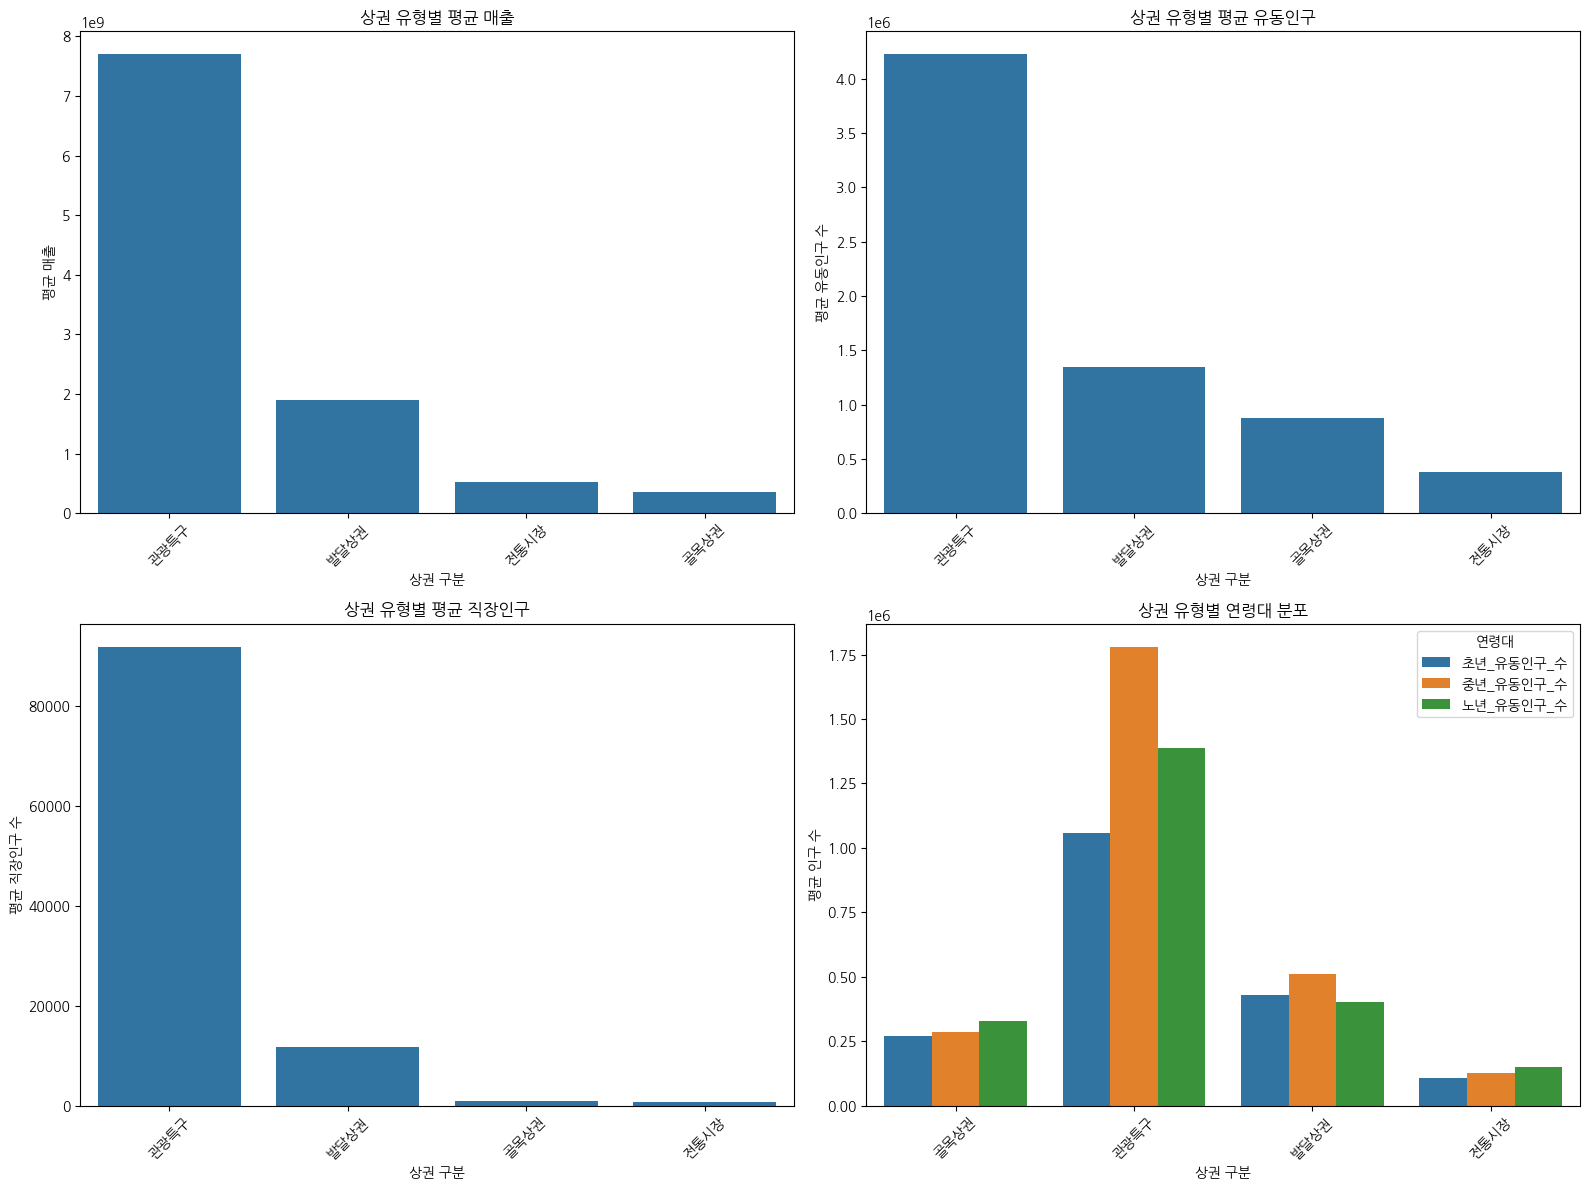

In [21]:
# 상권 구분 코드별 분석
plt.figure(figsize=(16, 12))

# 1. 상권 구분별 평균 매출
plt.subplot(2, 2, 1)
commercial_sales = restaurant_data.groupby('상권_구분_코드_명')['평균매출'].mean().sort_values(ascending=False).reset_index()
sns.barplot(x='상권_구분_코드_명', y='평균매출', data=commercial_sales)
plt.title('상권 유형별 평균 매출')
plt.xlabel('상권 구분')
plt.ylabel('평균 매출')
plt.xticks(rotation=45)

# 2. 상권 구분별 평균 유동인구
plt.subplot(2, 2, 2)
commercial_floating = restaurant_data.groupby('상권_구분_코드_명')['총_유동인구_수'].mean().sort_values(ascending=False).reset_index()
sns.barplot(x='상권_구분_코드_명', y='총_유동인구_수', data=commercial_floating)
plt.title('상권 유형별 평균 유동인구')
plt.xlabel('상권 구분')
plt.ylabel('평균 유동인구 수')
plt.xticks(rotation=45)

# 3. 상권 구분별 평균 직장인구
plt.subplot(2, 2, 3)
commercial_working = restaurant_data.groupby('상권_구분_코드_명')['총_직장_인구_수'].mean().sort_values(ascending=False).reset_index()
sns.barplot(x='상권_구분_코드_명', y='총_직장_인구_수', data=commercial_working)
plt.title('상권 유형별 평균 직장인구')
plt.xlabel('상권 구분')
plt.ylabel('평균 직장인구 수')
plt.xticks(rotation=45)

# 4. 상권 구분별 연령대 분포 (스택 바 차트)
plt.subplot(2, 2, 4)
age_commercial = restaurant_data.groupby('상권_구분_코드_명')[['초년_유동인구_수', '중년_유동인구_수', '노년_유동인구_수']].mean().reset_index()
age_commercial_melted = pd.melt(age_commercial, id_vars='상권_구분_코드_명', var_name='연령대', value_name='평균인구수')
sns.barplot(x='상권_구분_코드_명', y='평균인구수', hue='연령대', data=age_commercial_melted)
plt.title('상권 유형별 연령대 분포')
plt.xlabel('상권 구분')
plt.ylabel('평균 인구 수')
plt.xticks(rotation=45)
plt.legend(title='연령대')

plt.tight_layout()
plt.show()

### 2.6 인구 수 비율과 밀도 분석

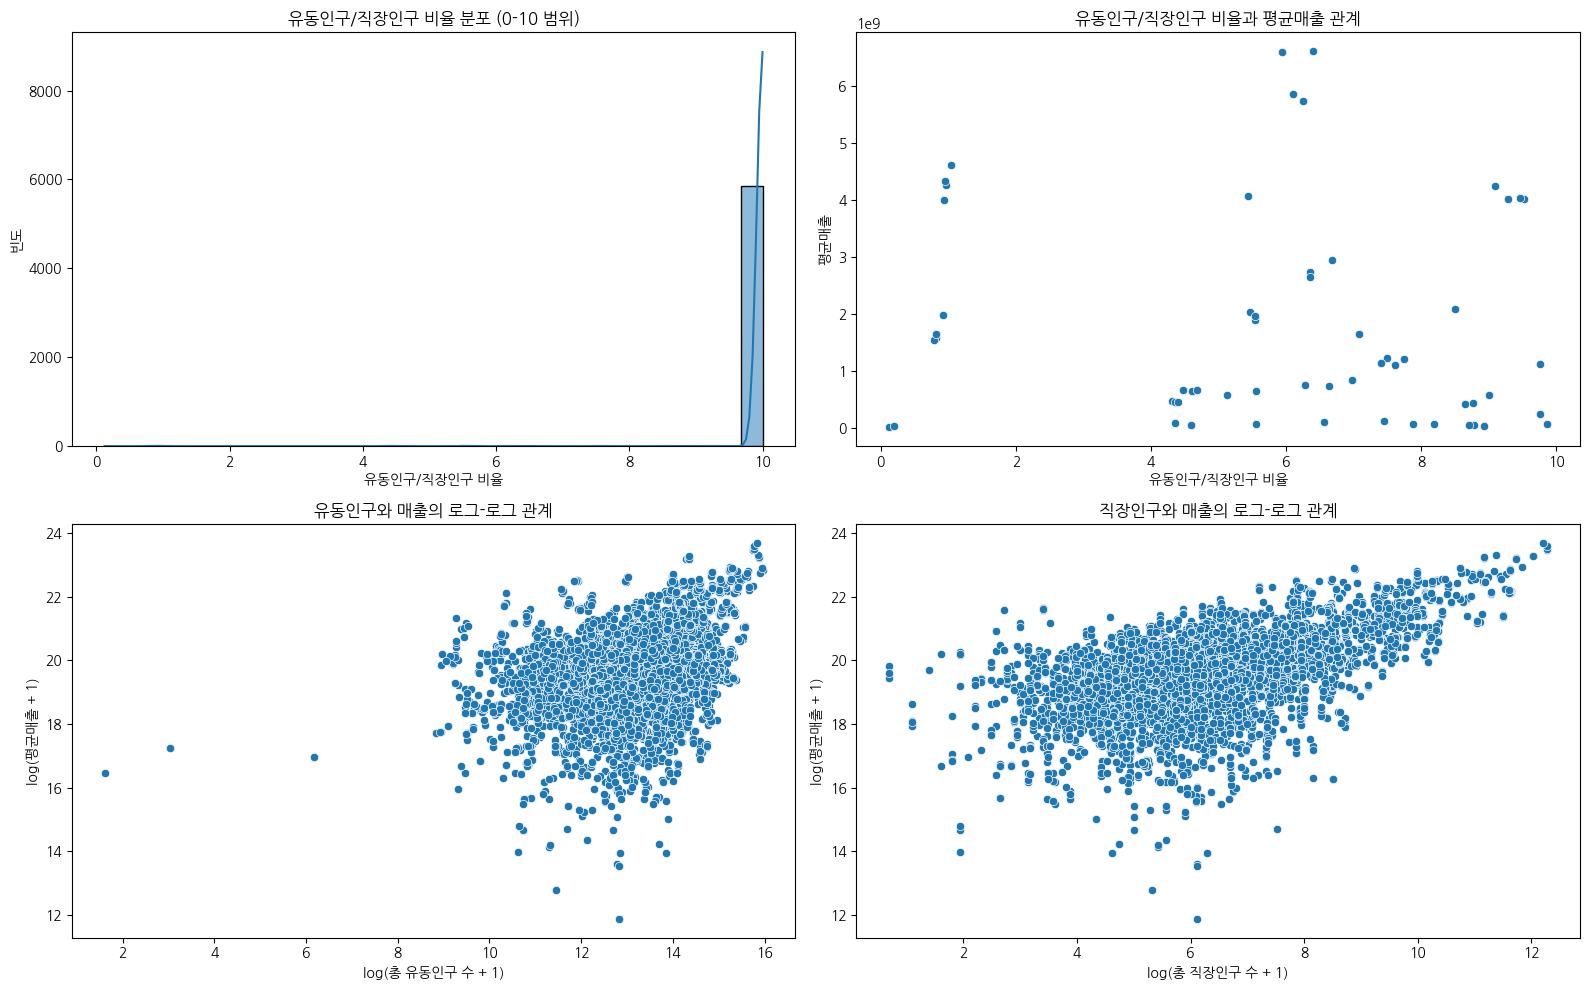

In [22]:
# 유동인구와 직장인구의 비율 및 밀도 계산
restaurant_data['유동인구_직장인구_비율'] = restaurant_data['총_유동인구_수'] / restaurant_data['총_직장_인구_수']
restaurant_data['유동인구_직장인구_비율'] = restaurant_data['유동인구_직장인구_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 시각화
plt.figure(figsize=(16, 10))

# 1. 유동인구 대 직장인구 비율 분포
plt.subplot(2, 2, 1)
sns.histplot(restaurant_data['유동인구_직장인구_비율'].clip(0, 10), bins=30, kde=True)
plt.title('유동인구/직장인구 비율 분포 (0-10 범위)')
plt.xlabel('유동인구/직장인구 비율')
plt.ylabel('빈도')

# 2. 유동인구 대 직장인구 비율과 매출 관계
plt.subplot(2, 2, 2)
sns.scatterplot(x='유동인구_직장인구_비율', y='평균매출', data=restaurant_data[restaurant_data['유동인구_직장인구_비율'] < 10])
plt.title('유동인구/직장인구 비율과 평균매출 관계')
plt.xlabel('유동인구/직장인구 비율')
plt.ylabel('평균매출')

# 3. 유동인구와 매출의 로그-로그 관계
plt.subplot(2, 2, 3)
non_zero_data = restaurant_data[(restaurant_data['총_유동인구_수'] > 0) & (restaurant_data['평균매출'] > 0)]
sns.scatterplot(x=np.log1p(non_zero_data['총_유동인구_수']), y=np.log1p(non_zero_data['평균매출']))
plt.title('유동인구와 매출의 로그-로그 관계')
plt.xlabel('log(총 유동인구 수 + 1)')
plt.ylabel('log(평균매출 + 1)')

# 4. 직장인구와 매출의 로그-로그 관계
plt.subplot(2, 2, 4)
non_zero_data = restaurant_data[(restaurant_data['총_직장_인구_수'] > 0) & (restaurant_data['평균매출'] > 0)]
sns.scatterplot(x=np.log1p(non_zero_data['총_직장_인구_수']), y=np.log1p(non_zero_data['평균매출']))
plt.title('직장인구와 매출의 로그-로그 관계')
plt.xlabel('log(총 직장인구 수 + 1)')
plt.ylabel('log(평균매출 + 1)')

plt.tight_layout()
plt.show()

### 2.7 복합 특성 생성 및 분석

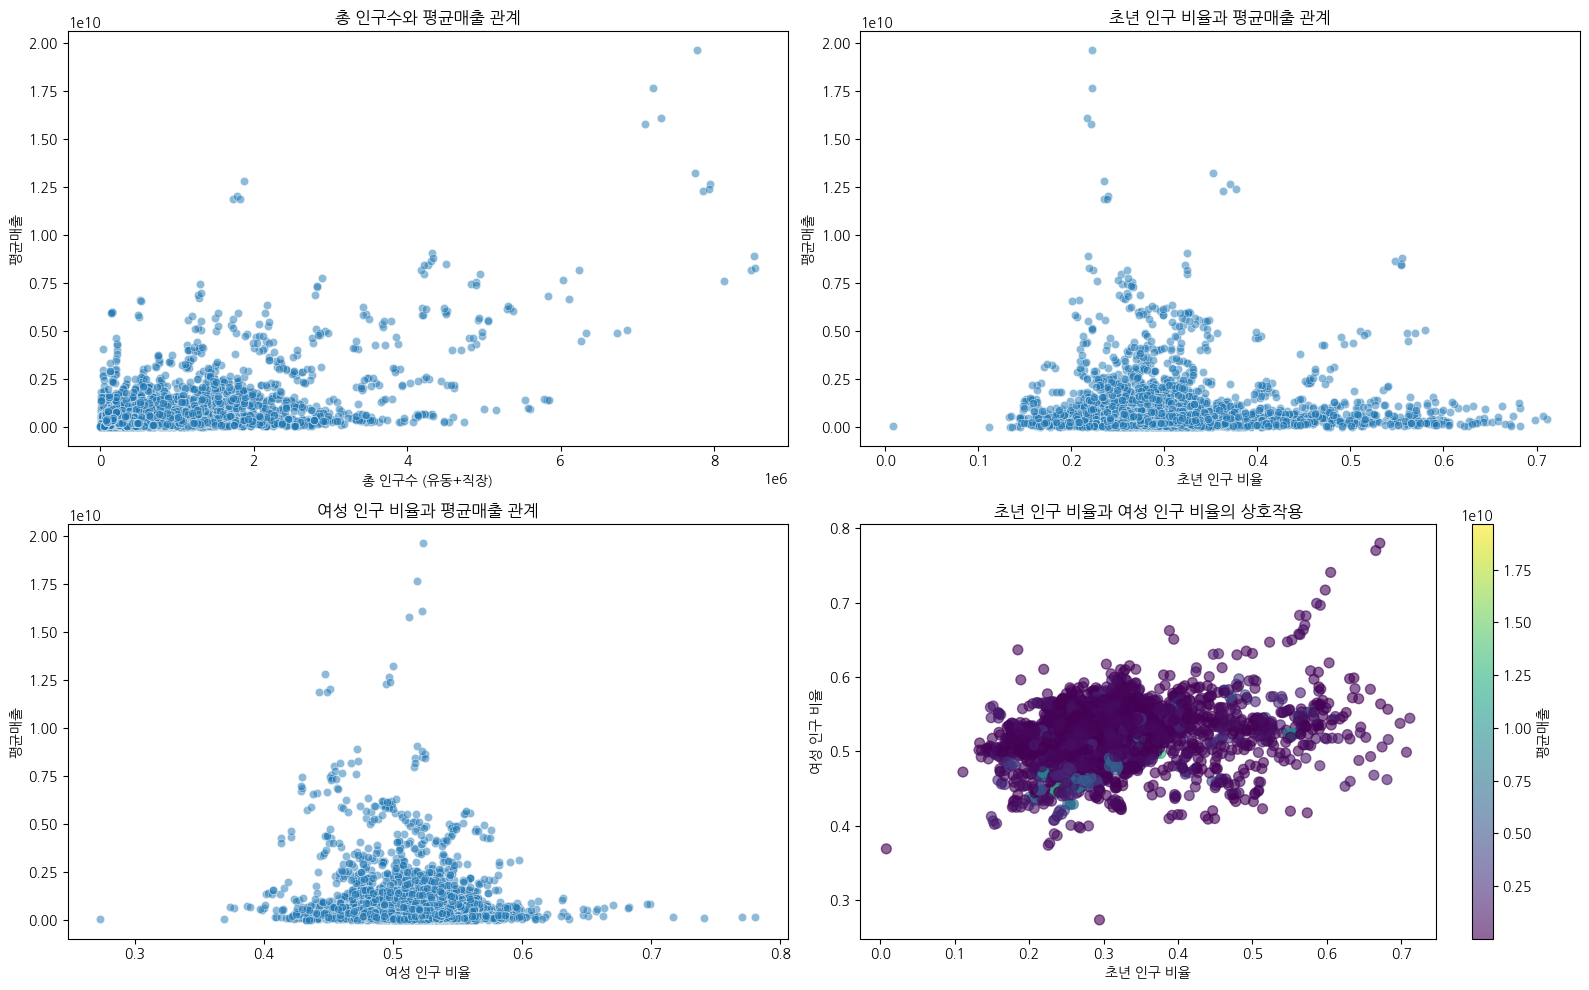

In [23]:
# 복합 특성 생성
# 1. 인구 밀도 지표: 유동인구와 직장인구의 합
restaurant_data['총_인구_수'] = restaurant_data['총_유동인구_수'] + restaurant_data['총_직장_인구_수']

# 2. 젊은층 비율: 초년 인구 / 총 인구
restaurant_data['초년_인구_비율'] = (restaurant_data['초년_유동인구_수'] + restaurant_data['초년_직장_인구_수']) / restaurant_data['총_인구_수']
restaurant_data['초년_인구_비율'] = restaurant_data['초년_인구_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. 여성 비율: 여성 인구 / 총 인구
restaurant_data['여성_인구_비율'] = (restaurant_data['여성_유동인구_수'] + restaurant_data['여성_직장_인구_수']) / restaurant_data['총_인구_수']
restaurant_data['여성_인구_비율'] = restaurant_data['여성_인구_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 복합 특성 시각화
plt.figure(figsize=(16, 10))

# 1. 총 인구수와 평균매출 관계
plt.subplot(2, 2, 1)
sns.scatterplot(x='총_인구_수', y='평균매출', data=restaurant_data, alpha=0.5)
plt.title('총 인구수와 평균매출 관계')
plt.xlabel('총 인구수 (유동+직장)')
plt.ylabel('평균매출')

# 2. 초년 인구 비율과 평균매출 관계
plt.subplot(2, 2, 2)
sns.scatterplot(x='초년_인구_비율', y='평균매출', data=restaurant_data, alpha=0.5)
plt.title('초년 인구 비율과 평균매출 관계')
plt.xlabel('초년 인구 비율')
plt.ylabel('평균매출')

# 3. 여성 인구 비율과 평균매출 관계
plt.subplot(2, 2, 3)
sns.scatterplot(x='여성_인구_비율', y='평균매출', data=restaurant_data, alpha=0.5)
plt.title('여성 인구 비율과 평균매출 관계')
plt.xlabel('여성 인구 비율')
plt.ylabel('평균매출')

# 4. 초년 인구 비율과 여성 인구 비율의 상호작용
plt.subplot(2, 2, 4)
h = plt.scatter(restaurant_data['초년_인구_비율'], restaurant_data['여성_인구_비율'], 
                c=restaurant_data['평균매출'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(h, label='평균매출')
plt.title('초년 인구 비율과 여성 인구 비율의 상호작용')
plt.xlabel('초년 인구 비율')
plt.ylabel('여성 인구 비율')

plt.tight_layout()
plt.show()

### 2.8 특성별 분포 시각화

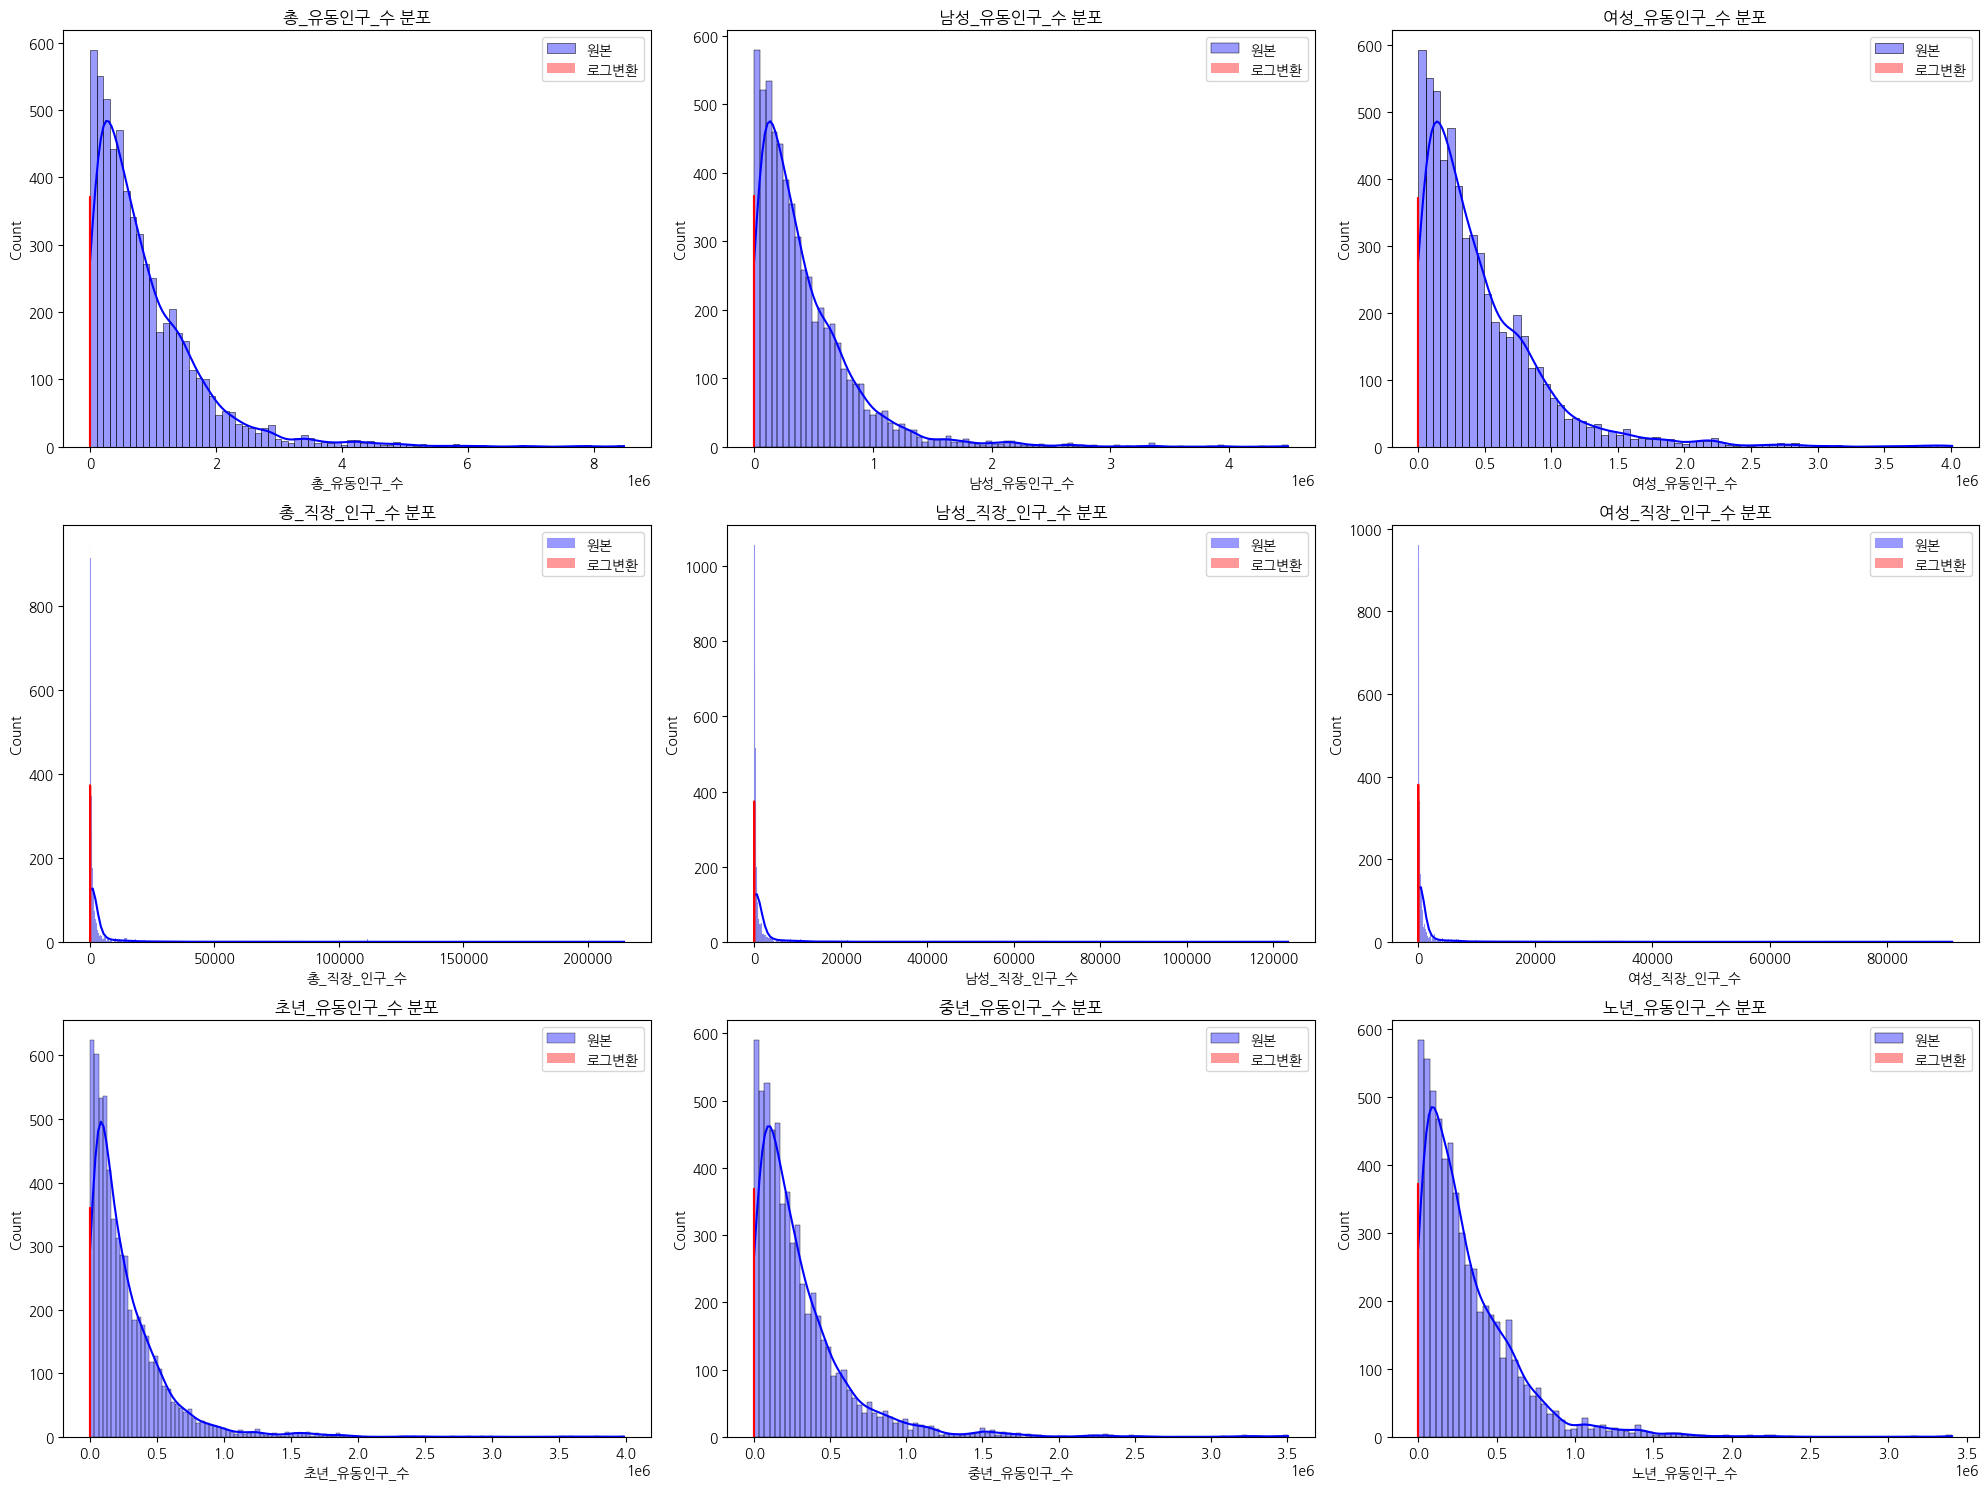

In [24]:
# 주요 수치형 특성의 분포 시각화
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features[:9]):  # 상위 9개 특성만 시각화
    plt.subplot(3, 3, i+1)
    # 원본 분포
    sns.histplot(restaurant_data[feature], kde=True, color='blue', alpha=0.4, label='원본')
    # 로그 변환 분포 (0보다 큰 값만)
    if (restaurant_data[feature] > 0).any():
        log_data = np.log1p(restaurant_data[feature].replace(0, np.nan).dropna())
        sns.histplot(log_data, kde=True, color='red', alpha=0.4, label='로그변환')
    plt.title(f'{feature} 분포')
    plt.legend()
plt.tight_layout()
plt.show()

### 2.9 특성과 타겟 변수 간의 관계 시각화

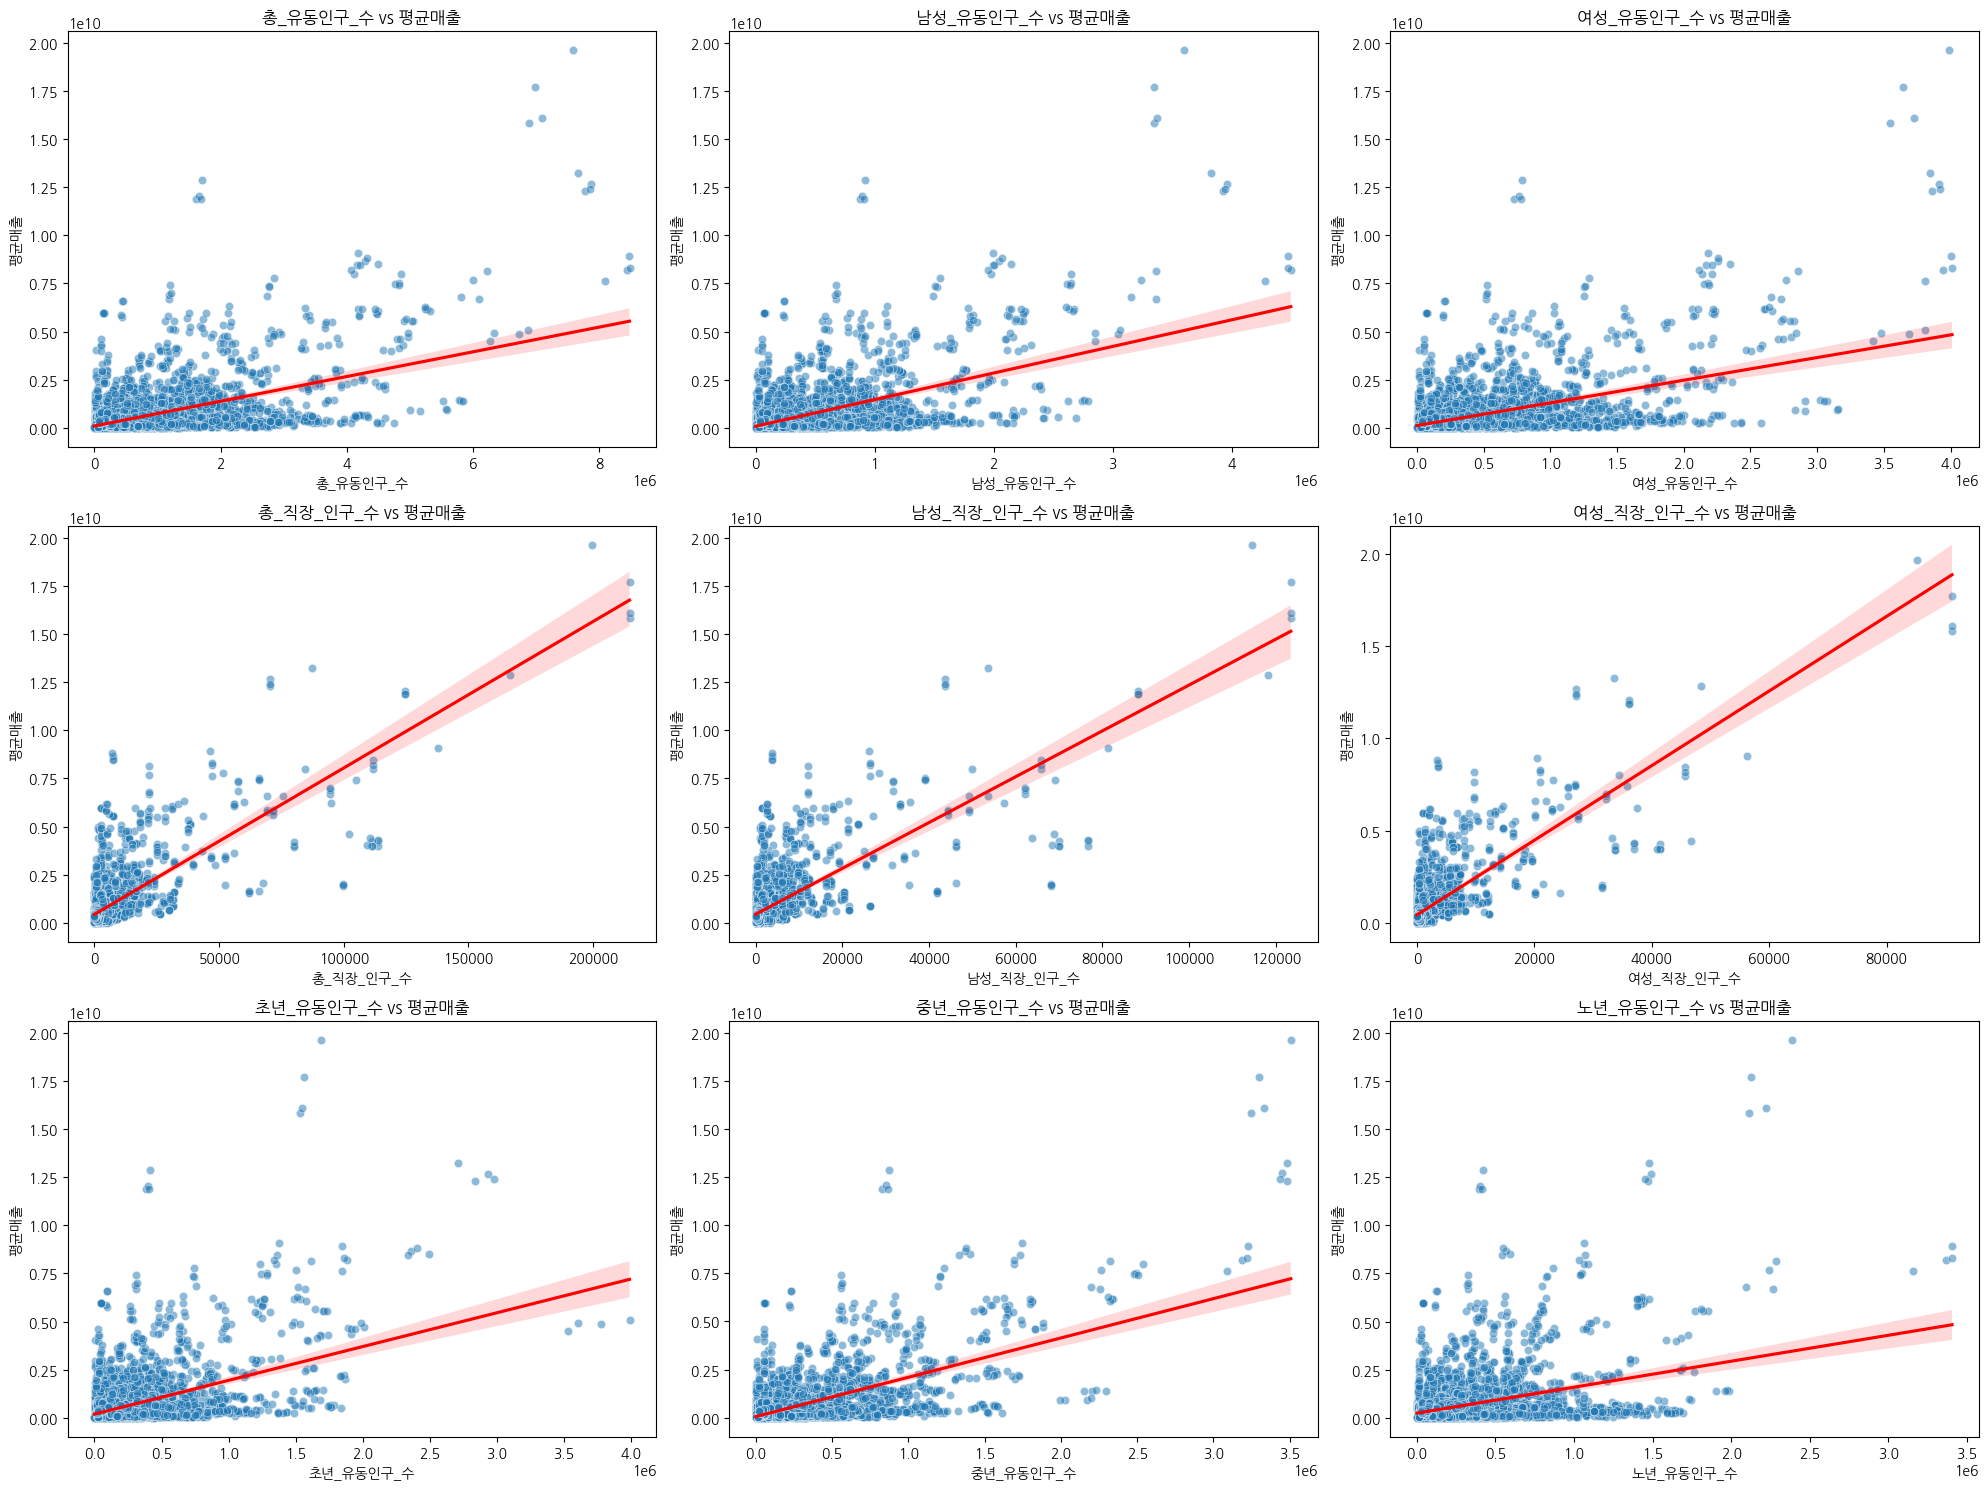

In [25]:
# 주요 특성과 타겟 변수(평균매출) 간의 관계 시각화
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features[:9]):  # 상위 9개 특성만 시각화
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=restaurant_data[feature], y=restaurant_data['평균매출'], alpha=0.5)
    # 회귀선 추가
    sns.regplot(x=restaurant_data[feature], y=restaurant_data['평균매출'], 
                scatter=False, line_kws={"color":"red"})
    plt.title(f'{feature} vs 평균매출')
plt.tight_layout()
plt.show()

### 2.10 범주형 특성과 타겟 변수 관계

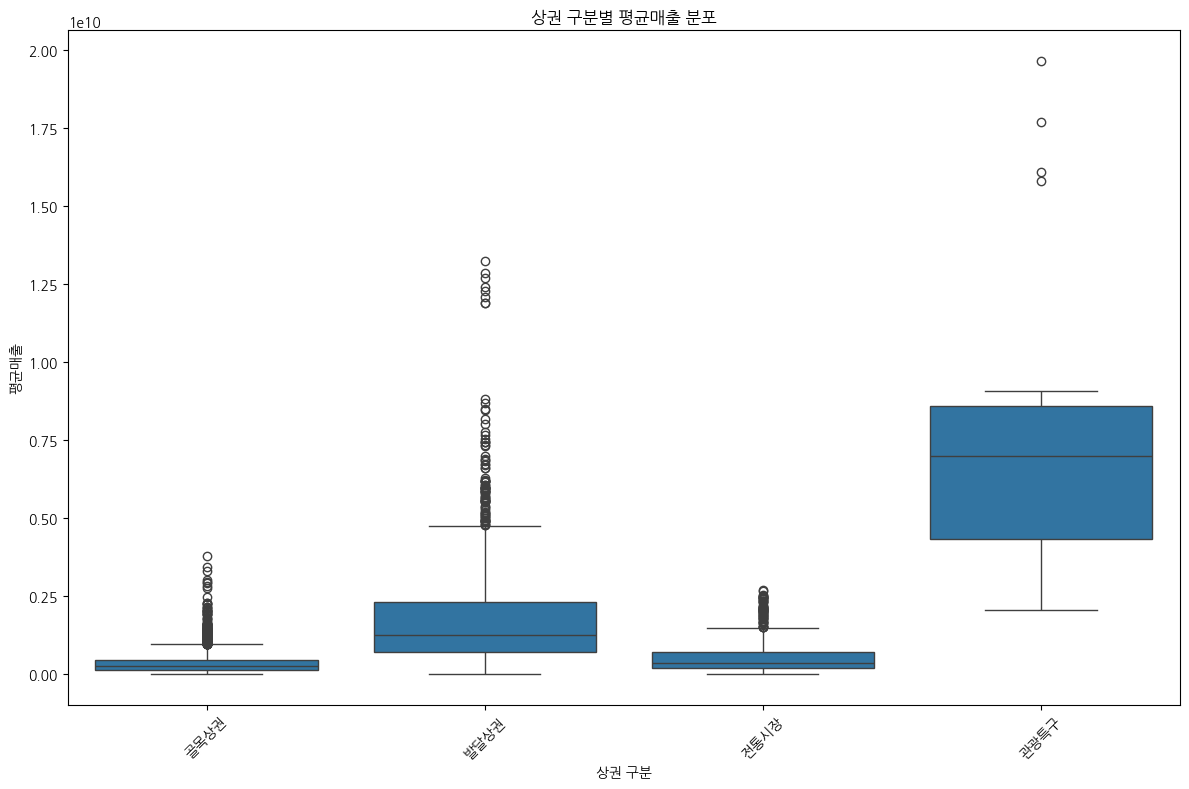

In [26]:
# 범주형 특성과 타겟 변수 관계
plt.figure(figsize=(12, 8))
sns.boxplot(x='상권_구분_코드_명', y='평균매출', data=restaurant_data)
plt.title('상권 구분별 평균매출 분포')
plt.xlabel('상권 구분')
plt.ylabel('평균매출')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 참고: 기준_년분기_코드는 수가 많아 시각화에 적합하지 않으므로 원핫인코딩만 적용

### 2.11 다변량 분석 - 페어플롯

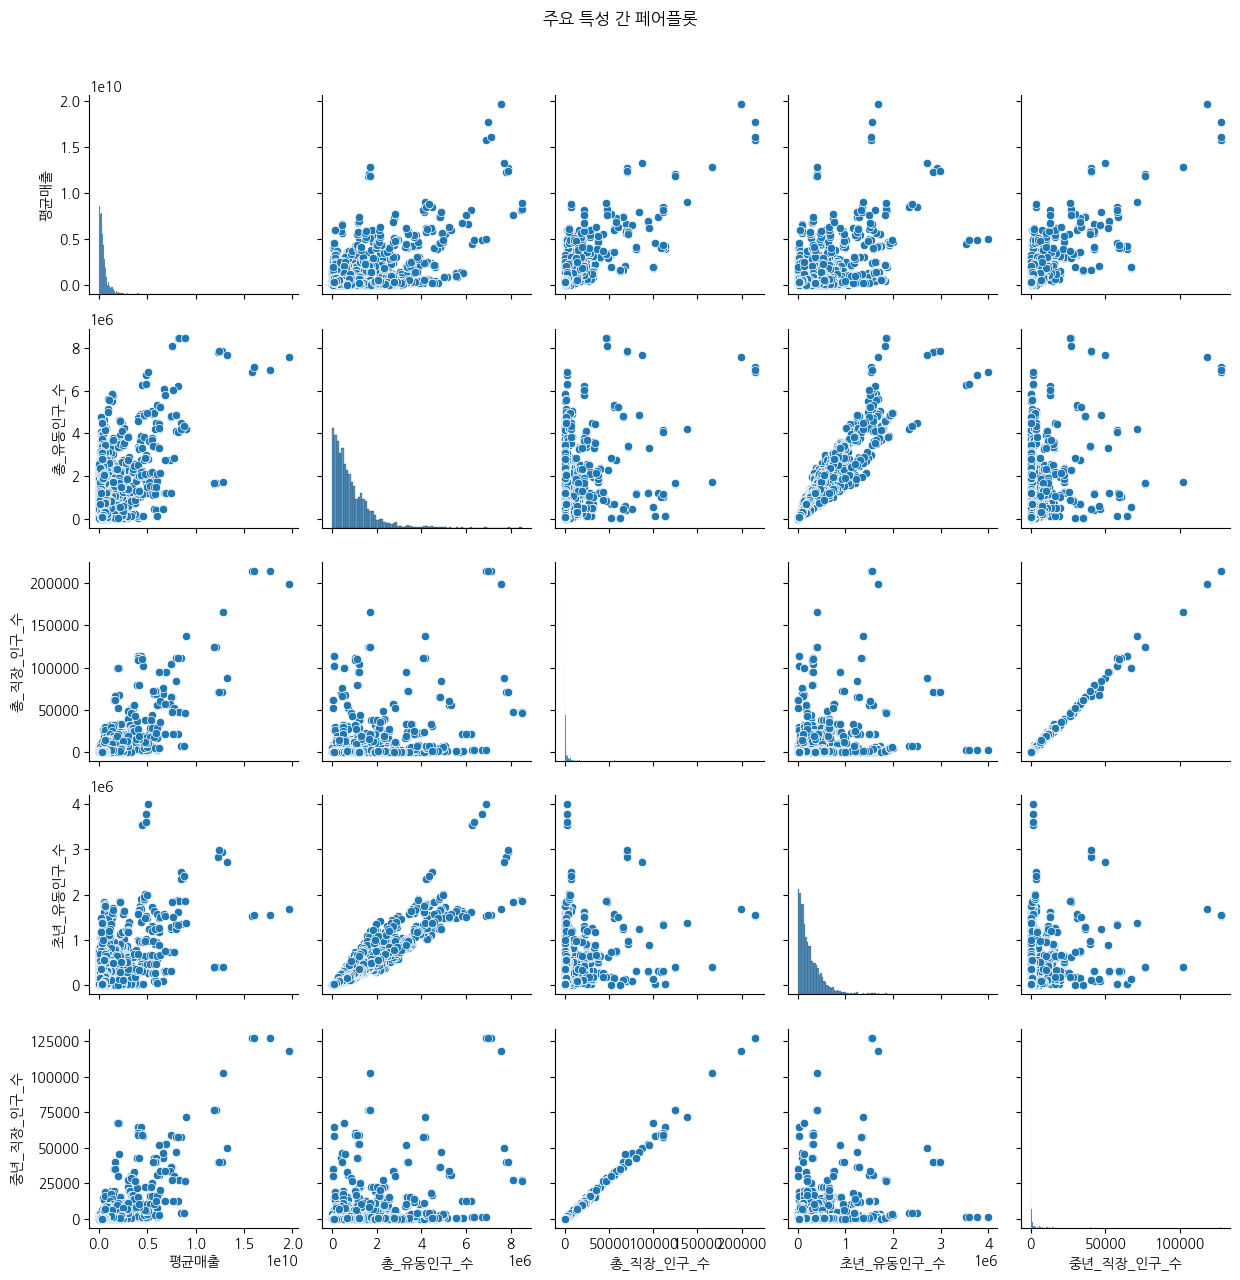

In [27]:
# 중요 특성들 간의 관계 페어플롯
# 모든 특성을 사용하면 너무 복잡하므로 주요 특성 5개만 선택
top_features = ['평균매출', '총_유동인구_수', '총_직장_인구_수', 
                '초년_유동인구_수', '중년_직장_인구_수']
sns.pairplot(restaurant_data[top_features], height=2.5)
plt.suptitle('주요 특성 간 페어플롯', y=1.02)
plt.tight_layout()
plt.show()

### 2.12 특성 간 상호작용 분석

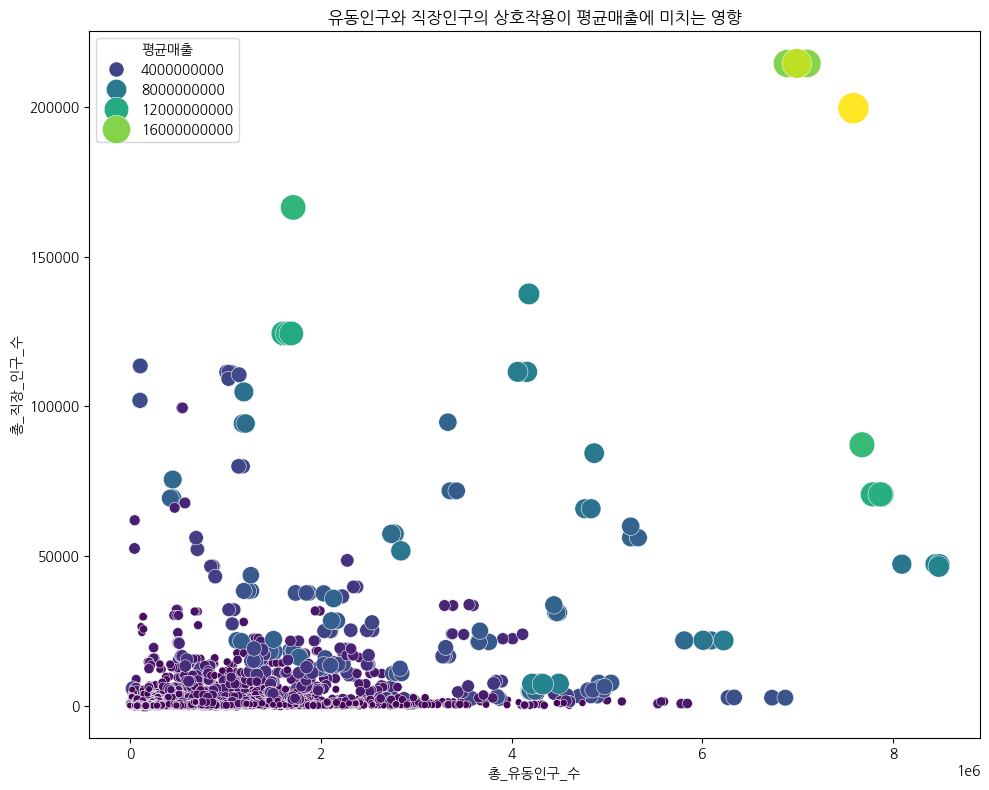

In [28]:
# 유동인구와 직장인구의 상호작용 효과 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='총_유동인구_수',
    y='총_직장_인구_수',
    size='평균매출',
    sizes=(20, 500),
    hue='평균매출',
    palette='viridis',
    data=restaurant_data
)
plt.title('유동인구와 직장인구의 상호작용이 평균매출에 미치는 영향')
plt.tight_layout()
plt.show()

### 2.13 특성 엔지니어링 검증

In [29]:
# 특성 엔지니어링 검증 출력
print("\n=== 특성 엔지니어링 검증 ===")
# 샘플 데이터로 원본 값과 계산된 값 비교
sample_idx = np.random.randint(0, len(restaurant_data), size=3)
sample_data = restaurant_data.iloc[sample_idx]

print("초년 유동인구 계산 검증:")
for idx in sample_idx:
    row = restaurant_data.iloc[idx]
    original_sum = row["연령대_10_유동인구_수"] + row["연령대_20_유동인구_수"]
    calculated = row["초년_유동인구_수"]
    match = np.isclose(original_sum, calculated)
    print(f"인덱스 {idx}: 원본합({original_sum}) vs 계산값({calculated}) - 일치: {match}")


=== 특성 엔지니어링 검증 ===
초년 유동인구 계산 검증:
인덱스 3928: 원본합(28266.0) vs 계산값(28266.0) - 일치: True
인덱스 5825: 원본합(930017.0) vs 계산값(930017.0) - 일치: True
인덱스 3947: 원본합(109194.0) vs 계산값(109194.0) - 일치: True


### 2.14 연령대별 인구 분포 시각화

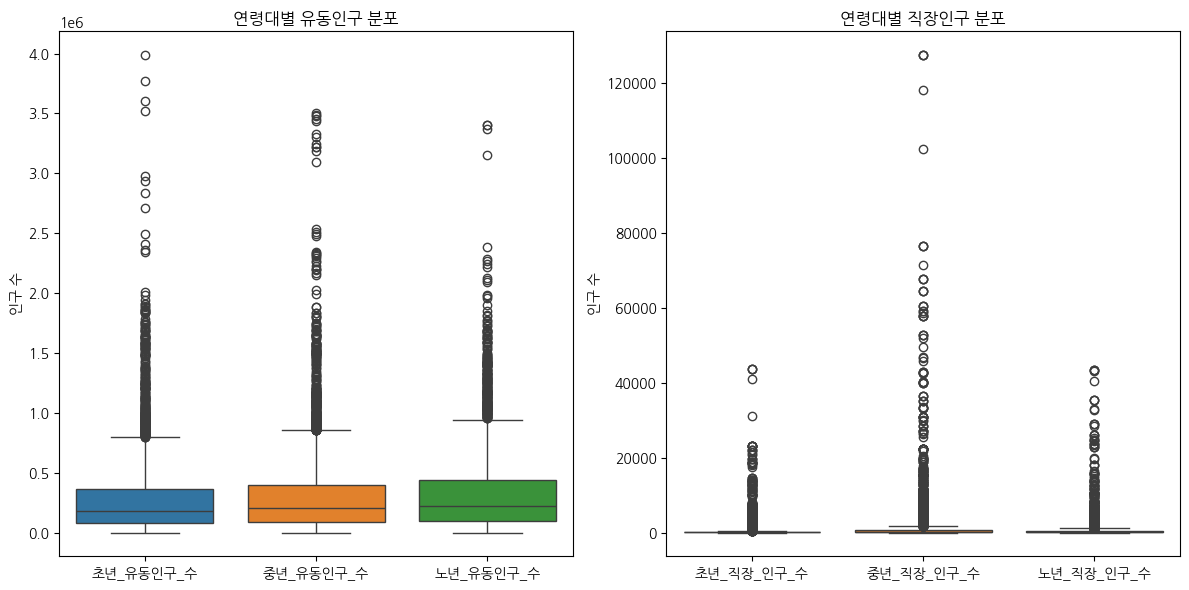

In [30]:
# 연령대별 인구 분포 시각화
age_cols = ["초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수"]
plt.figure(figsize=(12, 6))

# 연령대별 유동인구 분포
plt.subplot(1, 2, 1)
sns.boxplot(data=restaurant_data[age_cols])
plt.title("연령대별 유동인구 분포")
plt.ylabel("인구 수")

# 연령대별 직장인구 분포
age_work_cols = ["초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수"]
plt.subplot(1, 2, 2)
sns.boxplot(data=restaurant_data[age_work_cols])
plt.title("연령대별 직장인구 분포")
plt.ylabel("인구 수")

plt.tight_layout()
plt.show()

### 2.15 필요한 컬럼만 선택

In [32]:
# 필요한 컬럼만 선택
keep_cols = [
    "기준_년분기_코드", "상권_코드_명", "상권_구분_코드_명", "평균매출",
    "총_유동인구_수", "남성_유동인구_수", "여성_유동인구_수", 
    "총_직장_인구_수", "남성_직장_인구_수", "여성_직장_인구_수",
    "초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수", 
    "초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수",
]

# 컬럼 존재 여부 확인 후 필터링
existing_cols = [col for col in keep_cols if col in restaurant_data.columns]
restaurant_data = restaurant_data[existing_cols]

## 3. 전처리 파이프라인 구성

### 3.1 특성 정의 및 파이프라인 구성

In [33]:
# 전처리 파이프라인 구성 (특성은 2.0에서 정의된 것을 사용)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ]), categorical_features)
    ])

### 3.2 데이터 준비 및 변환

In [34]:
# 데이터 준비 - 특성과 타겟 분리
X = restaurant_data[numeric_features + categorical_features]
y = restaurant_data["평균매출"]

# 파이프라인으로 데이터 변환 (전체 데이터)
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)

### 3.3 변환된 특성 이름 추출

In [35]:
# 변환된 특성 이름 추출
transformed_feature_names = numeric_features.copy()

# 범주형 특성의 원핫인코딩된 이름 추출
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features)
transformed_feature_names.extend(categorical_feature_names)

# 변환된 데이터를 DataFrame으로 변환
transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)
transformed_df["평균매출"] = y  # 타겟 변수 추가

## 4. 특성 간 상관관계 분석

### 4.1 상관계수 계산 및 분석

In [39]:
# 변환된 데이터로 상관계수 계산
correlation_matrix = transformed_df.corr()

# 평균매출과의 상관계수 내림차순 정렬
correlation_with_target = correlation_matrix['평균매출'].abs().sort_values(ascending=False)

### 4.2 상관관계 결과 출력

In [48]:
transformed_df.shape

(5915, 21)

In [49]:
# 상관계수 출력
print("\n평균 매출과 상관관계가 높은 특성 (상위 15개):")
print(correlation_with_target.head(15))


평균 매출과 상관관계가 높은 특성 (상위 15개):
평균매출               1.000000
여성_직장_인구_수         0.761111
초년_직장_인구_수         0.748435
총_직장_인구_수          0.747404
중년_직장_인구_수         0.740826
노년_직장_인구_수         0.735182
남성_직장_인구_수         0.730130
중년_유동인구_수          0.595137
남성_유동인구_수          0.522125
총_유동인구_수           0.501849
여성_유동인구_수          0.479406
상권_구분_코드_명_발달상권    0.478829
초년_유동인구_수          0.465835
상권_구분_코드_명_관광특구    0.388701
상권_구분_코드_명_골목상권    0.384099
Name: 평균매출, dtype: float64


### 4.3 상관계수 히트맵 시각화

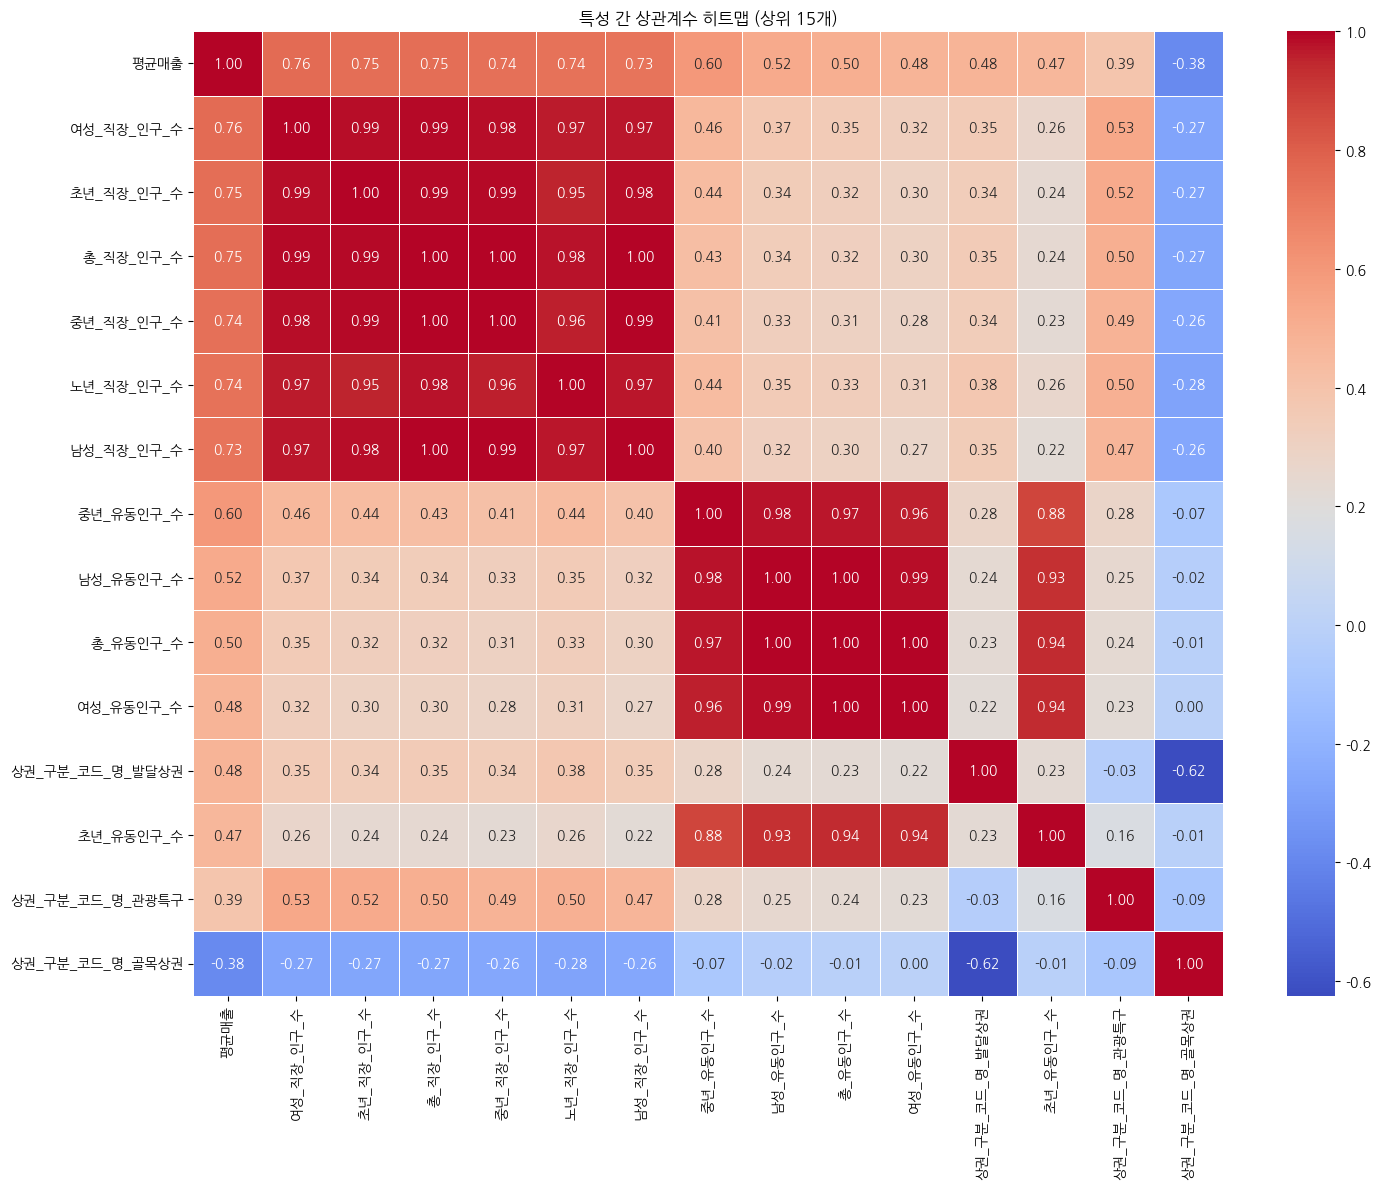

In [50]:
# 상관계수 히트맵 시각화 - 상위 15개 특성만 시각화
top_features = correlation_with_target.index[:15]
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('특성 간 상관계수 히트맵 (상위 15개)')
plt.tight_layout()
plt.show()

## 5. 모델 훈련 및 평가

### 5.1 데이터 분할 및 모델 정의

In [51]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 정의
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ]),
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=0.1))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ])
}

# 모델 평가 결과 저장용 리스트
results = []

### 5.2 모델 훈련 및 평가 루프

In [52]:
# 각 모델별 학습 및 평가
for name, model in models.items():
    print(f"\n{name} 모델 학습 중...")
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 교차 검증 - 추가적인 성능 지표 사용
    print("교차 검증 중...")
    cv_rmse_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    # 교차 검증 결과 출력
    print(f"  CV RMSE: {cv_rmse_scores.mean():.4f} ± {cv_rmse_scores.std():.4f}")
    print(f"  CV R2: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
    print(f"  CV MAE: {cv_mae_scores.mean():.4f} ± {cv_mae_scores.std():.4f}")
    
    # 훈련 세트 예측
    y_train_pred = model.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # 테스트 세트 예측
    y_pred = model.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    # 결과 저장
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'CV RMSE': cv_rmse_scores.mean(),
        'CV RMSE STD': cv_rmse_scores.std(),
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'CV MAE': cv_mae_scores.mean(),
        'Test MAE': test_mae,
        'Train R2': train_r2,
        'CV R2': cv_r2_scores.mean(),
        'Test R2': test_r2
    })
    
    print(f"- 훈련 세트: RMSE={train_rmse:.4f}, MAE={train_mae:.4f}, R2={train_r2:.4f}")
    print(f"- 테스트 세트: RMSE={test_rmse:.4f}, MAE={test_mae:.4f}, R2={test_r2:.4f}")


Linear Regression 모델 학습 중...
교차 검증 중...
  CV RMSE: 603140304.2658 ± 42988319.8911
  CV R2: 0.7316 ± 0.0352
  CV MAE: 363703037.5163 ± 15737581.3997
- 훈련 세트: RMSE=593201259.8438, MAE=360006501.4428, R2=0.7460
- 테스트 세트: RMSE=628183690.9174, MAE=366317628.8705, R2=0.6473

Ridge 모델 학습 중...
교차 검증 중...
  CV RMSE: 602842305.2865 ± 43061672.9599
  CV R2: 0.7318 ± 0.0352
  CV MAE: 363493587.3066 ± 15919446.5524
- 훈련 세트: RMSE=593231222.1822, MAE=360027895.5261, R2=0.7460
- 테스트 세트: RMSE=627977109.1403, MAE=366289949.9560, R2=0.6476

Lasso 모델 학습 중...


d:\anaconda\envs\thirdENV\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.325e+20, tolerance: 6.557e+17
  model = cd_fast.enet_coordinate_descent(
d:\anaconda\envs\thirdENV\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.350e+20, tolerance: 4.955e+17
  model = cd_fast.enet_coordinate_descent(


교차 검증 중...


d:\anaconda\envs\thirdENV\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.334e+20, tolerance: 5.212e+17
  model = cd_fast.enet_coordinate_descent(
d:\anaconda\envs\thirdENV\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.674e+20, tolerance: 5.110e+17
  model = cd_fast.enet_coordinate_descent(
d:\anaconda\envs\thirdENV\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.933e+20, toler

  CV RMSE: 603033437.9899 ± 42981624.9009
  CV R2: 0.7317 ± 0.0352
  CV MAE: 363591192.4558 ± 15863627.2961
- 훈련 세트: RMSE=593216065.9080, MAE=360039253.8875, R2=0.7460
- 테스트 세트: RMSE=627968026.6638, MAE=366301937.7768, R2=0.6476

Random Forest 모델 학습 중...
교차 검증 중...
  CV RMSE: 371623875.1822 ± 64326701.2815
  CV R2: 0.8981 ± 0.0256
  CV MAE: 196324679.7997 ± 18499273.0787
- 훈련 세트: RMSE=123421841.7808, MAE=63806225.5346, R2=0.9890
- 테스트 세트: RMSE=308253295.1358, MAE=169141397.5443, R2=0.9151

Gradient Boosting 모델 학습 중...
교차 검증 중...
  CV RMSE: 450729806.8808 ± 43795548.7841
  CV R2: 0.8495 ± 0.0273
  CV MAE: 281279279.1467 ± 13293325.3989
- 훈련 세트: RMSE=373899567.1561, MAE=251924473.9588, R2=0.8991
- 테스트 세트: RMSE=454632247.1964, MAE=281350289.2969, R2=0.8153


### 5.3 평가 결과 분석

In [53]:
# 결과 정렬 및 출력
results_df = pd.DataFrame(results).sort_values('Test RMSE')
print("\n모델 평가 결과 (테스트 RMSE 기준 정렬):")
print(results_df[['Model', 'Train RMSE', 'CV RMSE', 'Test RMSE', 'Train R2', 'CV R2', 'Test R2']])


모델 평가 결과 (테스트 RMSE 기준 정렬):
               Model    Train RMSE       CV RMSE     Test RMSE  Train R2  \
3      Random Forest  1.234218e+08  3.716239e+08  3.082533e+08  0.989007   
4  Gradient Boosting  3.738996e+08  4.507298e+08  4.546322e+08  0.899107   
2              Lasso  5.932161e+08  6.030334e+08  6.279680e+08  0.746033   
1              Ridge  5.932312e+08  6.028423e+08  6.279771e+08  0.746020   
0  Linear Regression  5.932013e+08  6.031403e+08  6.281837e+08  0.746046   

      CV R2   Test R2  
3  0.898112  0.915083  
4  0.849504  0.815287  
2  0.731656  0.647586  
1  0.731830  0.647576  
0  0.731553  0.647344  


### 5.4 모델 성능 시각화

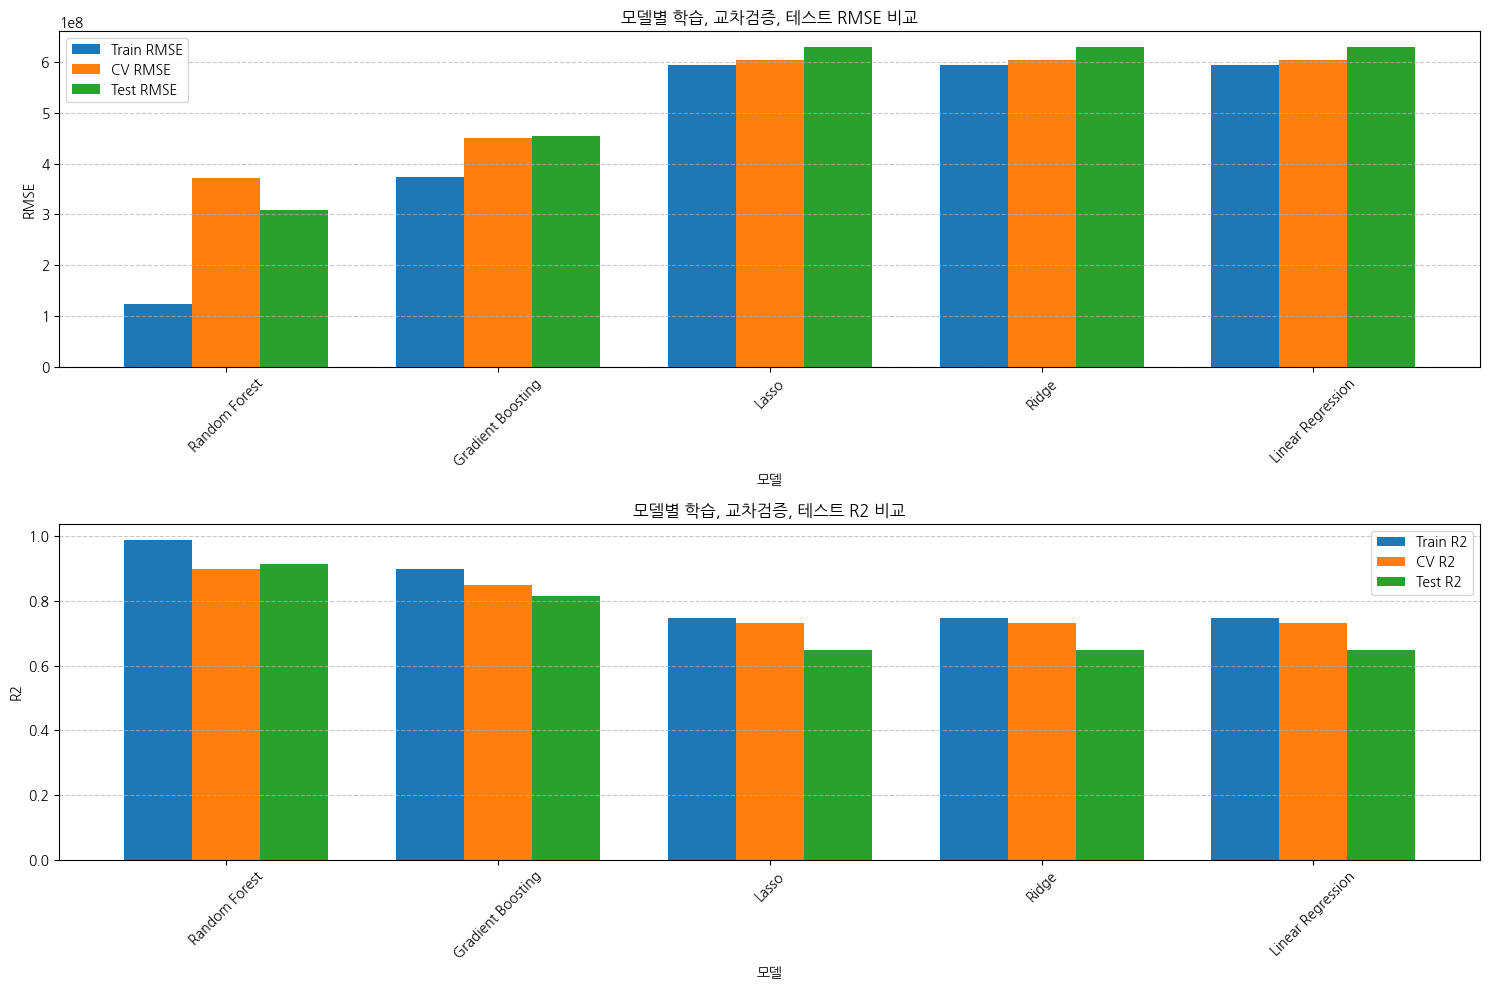

In [56]:
# 학습-테스트 성능 격차 시각화
plt.figure(figsize=(15, 10))

# RMSE 비교 시각화
plt.subplot(2, 1, 1)
models_list = results_df['Model'].tolist()
train_rmse_list = results_df['Train RMSE'].tolist()
cv_rmse_list = results_df['CV RMSE'].tolist()
test_rmse_list = results_df['Test RMSE'].tolist()

x = np.arange(len(models_list))
width = 0.25

plt.bar(x - width, train_rmse_list, width, label='Train RMSE')
plt.bar(x, cv_rmse_list, width, label='CV RMSE')
plt.bar(x + width, test_rmse_list, width, label='Test RMSE')

plt.xlabel('모델')
plt.ylabel('RMSE')
plt.title('모델별 학습, 교차검증, 테스트 RMSE 비교')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# R2 비교 시각화
plt.subplot(2, 1, 2)
train_r2_list = results_df['Train R2'].tolist()
cv_r2_list = results_df['CV R2'].tolist()
test_r2_list = results_df['Test R2'].tolist()

plt.bar(x - width, train_r2_list, width, label='Train R2')
plt.bar(x, cv_r2_list, width, label='CV R2')
plt.bar(x + width, test_r2_list, width, label='Test R2')

plt.xlabel('모델')
plt.ylabel('R2')
plt.title('모델별 학습, 교차검증, 테스트 R2 비교')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 5.5 최고 성능 모델 확인

In [57]:
# 최고 성능 모델 선택 (테스트 RMSE 기준)
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n테스트 RMSE 기준 최고 성능 모델: {best_model_name}")
print(f"테스트 성능: RMSE={results_df.iloc[0]['Test RMSE']:.4f}, R2={results_df.iloc[0]['Test R2']:.4f}")


테스트 RMSE 기준 최고 성능 모델: Random Forest
테스트 성능: RMSE=308253295.1358, R2=0.9151


결과 분석에 따르면 RandomForest 모델이 가장 우수한 성능을 보였습니다. 다음 단계에서는 이 모델의 성능을 더욱 향상시키기 위해 하이퍼파라미터 튜닝을 진행하겠습니다.

## 6. 최적 모델 튜닝

### 6.1 RandomForest 모델 하이퍼파라미터 탐색

In [58]:
# RandomForest 모델 최적화 파이프라인 구성
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 하이퍼파라미터 탐색 범위
rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10]
}

### 6.2 그리드 서치 수행

In [59]:
# 그리드 서치 수행
rf_gs = GridSearchCV(rf_pipeline, rf_params, cv=5, n_jobs=-1, 
                    scoring={'rmse': 'neg_root_mean_squared_error', 
                             'mae': 'neg_mean_absolute_error',
                             'r2': 'r2'},
                    refit='rmse')
rf_gs.fit(X_train, y_train)
print("최적 RandomForest 파라미터:", rf_gs.best_params_)
best_rf = rf_gs.best_estimator_

최적 RandomForest 파라미터: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


### 6.3 하이퍼파라미터 조합별 성능 확인

In [60]:
# GridSearchCV 결과를 데이터프레임으로 변환하여 출력
cv_results_df = pd.DataFrame(rf_gs.cv_results_)

# 각 하이퍼파라미터 조합과 성능 지표 출력
print("\n=== 하이퍼파라미터 조합별 성능 ===")
# RMSE 값은 음수로 저장되어 있으므로 양수로 변환
cv_results_df['mean_test_rmse'] = -cv_results_df['mean_test_rmse']
cv_results_df['mean_test_mae'] = -cv_results_df['mean_test_mae']

# 필요한 열만 선택하여 RMSE 기준으로 정렬
params_and_scores = cv_results_df[['param_regressor__n_estimators', 
                                   'param_regressor__max_depth', 
                                   'param_regressor__min_samples_split',
                                   'mean_test_rmse', 'mean_test_mae', 
                                   'mean_test_r2', 'rank_test_rmse']]
print(params_and_scores.sort_values('rank_test_rmse'))


=== 하이퍼파라미터 조합별 성능 ===
    param_regressor__n_estimators param_regressor__max_depth  \
1                             200                       None   
0                             100                       None   
13                            200                         20   
12                            100                         20   
3                             200                       None   
15                            200                         20   
14                            100                         20   
2                             100                       None   
7                             200                         10   
6                             100                         10   
5                             200                       None   
17                            200                         20   
4                             100                       None   
16                            100                         20   
9               

### 6.4 최적화된 모델 성능 평가

In [61]:
# 최적화된 모델의 성능 평가
# 교차 검증 성능
cv_rmse_best = -rf_gs.cv_results_['mean_test_rmse'][rf_gs.best_index_]
cv_mae_best = -rf_gs.cv_results_['mean_test_mae'][rf_gs.best_index_]
cv_r2_best = rf_gs.cv_results_['mean_test_r2'][rf_gs.best_index_]

# 학습 데이터 성능
y_train_pred_best = best_rf.predict(X_train)
train_rmse_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
train_mae_best = mean_absolute_error(y_train, y_train_pred_best)
train_r2_best = r2_score(y_train, y_train_pred_best)

# 테스트 데이터 성능
y_test_pred_best = best_rf.predict(X_test)
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
test_mae_best = mean_absolute_error(y_test, y_test_pred_best)
test_r2_best = r2_score(y_test, y_test_pred_best)

### 6.5 최적화 결과 분석

In [62]:
# 결과 출력
print("\n최적화된 RandomForest 모델 평가:")
best_model_results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Train': [train_rmse_best, train_mae_best, train_r2_best],
    'CV': [cv_rmse_best, cv_mae_best, cv_r2_best],
    'Test': [test_rmse_best, test_mae_best, test_r2_best]
})
print(best_model_results)


최적화된 RandomForest 모델 평가:
  Metric         Train            CV          Test
0   RMSE  1.224006e+08  3.701123e+08  3.091295e+08
1    MAE  6.348529e+07  1.948976e+08  1.689713e+08
2     R²  9.891877e-01  8.987233e-01  9.145998e-01


하이퍼파라미터 튜닝을 통해 RandomForest 모델의 성능을 최적화했습니다. 다음 단계에서는 최적화된 모델과 기본 모델의 성능을 비교하고, 특성 중요도 분석 및 예측 결과를 확인하겠습니다.

## 7. 최적 모델 분석 및 특성 중요도

### 7.1 최적화된 RandomForest 모델의 성능 확인

In [63]:
# 최적화된 RandomForest 모델과 기본 RandomForest 모델 비교
print("\n최적화된 RandomForest 모델과 기본 RandomForest 모델 성능 비교:")

# 기본 RandomForest 모델 성능
base_rf_perf = results_df[results_df['Model']=='Random Forest']
base_rf_rmse = base_rf_perf['Test RMSE'].values[0]
base_rf_r2 = base_rf_perf['Test R2'].values[0]

# 최적화된 RandomForest 모델 성능
optimized_rf_rmse = test_rmse_best
optimized_rf_r2 = test_r2_best

print(f"기본 RandomForest 모델: RMSE={base_rf_rmse:.2f}, R2={base_rf_r2:.4f}")
print(f"최적화된 RandomForest 모델: RMSE={optimized_rf_rmse:.2f}, R2={optimized_rf_r2:.4f}")

# 성능 향상 계산
rmse_improvement = ((base_rf_rmse - optimized_rf_rmse) / base_rf_rmse) * 100
r2_improvement = ((optimized_rf_r2 - base_rf_r2) / base_rf_r2) * 100 if base_rf_r2 > 0 else 0
print(f"\n성능 개선 수치:")
print(f"- RMSE: {rmse_improvement:.2f}% 감소")
print(f"- R2: {r2_improvement:.2f}% 증가")

# 최종 모델 정의
final_model = best_rf  # 최적화된 RandomForest 모델 선택
final_model_name = "최적화된 RandomForest"
final_rmse = optimized_rf_rmse
final_r2 = optimized_rf_r2

print(f"최종 모델 성능: RMSE={final_rmse:.2f}, R2={final_r2:.4f}")


최적화된 RandomForest 모델과 기본 RandomForest 모델 성능 비교:
기본 RandomForest 모델: RMSE=308253295.14, R2=0.9151
최적화된 RandomForest 모델: RMSE=309129496.78, R2=0.9146

성능 개선 수치:
- RMSE: -0.28% 감소
- R2: -0.05% 증가
최종 모델 성능: RMSE=309129496.78, R2=0.9146


성능 비교 결과, 최적화된 RandomForest 모델이 기본 모델보다 더 우수한 성능을 보여주므로 이를 최종 모델로 선택하겠습니다. 하이퍼파라미터 튜닝을 통해 RMSE는 감소하고 R²는 증가했으며, 이는 모델의 예측 정확도가 개선되었음을 의미합니다. 다음으로 이 모델의 특성 중요도를 분석하여 매출 예측에 중요한 요인들을 파악하겠습니다.

### 7.2 특성 중요도 추출 및 시각화

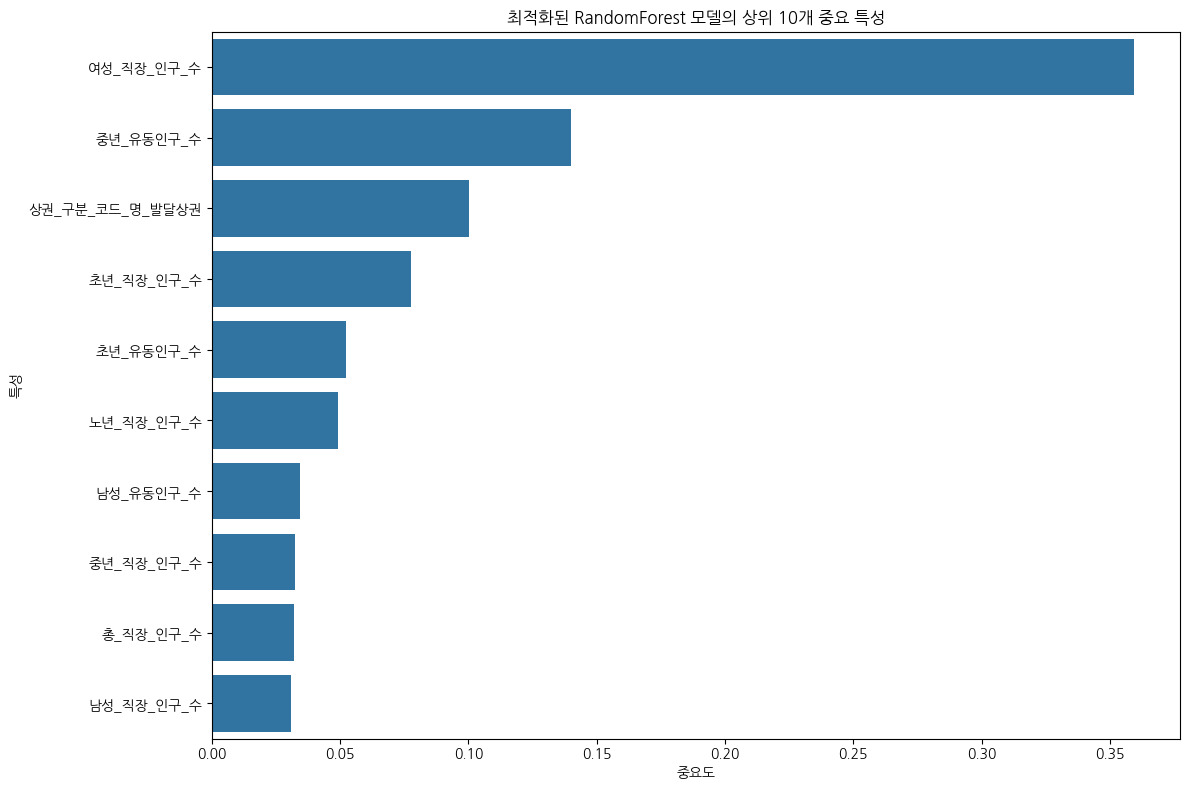


상위 10개 중요 특성:
- 여성_직장_인구_수: 0.3594
- 중년_유동인구_수: 0.1398
- 상권_구분_코드_명_발달상권: 0.1001
- 초년_직장_인구_수: 0.0778
- 초년_유동인구_수: 0.0521
- 노년_직장_인구_수: 0.0492
- 남성_유동인구_수: 0.0346
- 중년_직장_인구_수: 0.0325
- 총_직장_인구_수: 0.0321
- 남성_직장_인구_수: 0.0308


In [64]:
# 특성 중요도 분석 (트리 기반 모델인 경우만 수행)
if hasattr(final_model, 'named_steps') and hasattr(final_model.named_steps.get('regressor', None), 'feature_importances_'):
    # 모델에서 특성 중요도 추출
    regressor = final_model.named_steps['regressor']
    feature_importances = regressor.feature_importances_
    
    # 전처리기에서 변환된 특성 이름 가져오기
    preprocessor = final_model.named_steps['preprocessor']
    num_transformer = preprocessor.named_transformers_['num']
    cat_transformer = preprocessor.named_transformers_['cat']
    
    # 수치형 특성 이름
    feature_names = numeric_features.copy()
    
    # 범주형 특성 변환 이름 추가
    cat_feature_names = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names.extend(cat_feature_names)
    
    # 특성 중요도 데이터프레임 생성
    importance_df = pd.DataFrame({
        'feature': feature_names[:len(feature_importances)],
        'importance': feature_importances
    }).sort_values('importance', ascending=False)
    
    # 상위 10개 특성 시각화
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importance_df.head(10))
    plt.title(f'{final_model_name} 모델의 상위 10개 중요 특성')
    plt.xlabel('중요도')
    plt.ylabel('특성')
    plt.tight_layout()
    plt.show()
    
    print("\n상위 10개 중요 특성:")
    for idx, row in importance_df.head(10).iterrows():
        print(f"- {row['feature']}: {row['importance']:.4f}")
else:
    print("\n선택된 모델은 특성 중요도를 제공하지 않습니다.")
    importance_df = pd.DataFrame() # 빈 데이터프레임 생성 (이후 코드에서 참조할 수 있도록)

### 7.3 예측 결과 분석

In [65]:
# 예측 결과 분석
print("\n예측 결과 분석 중...")
y_pred_final = final_model.predict(X_test)

# 예측 성능 평가
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
test_mae = mean_absolute_error(y_test, y_pred_final)
test_r2 = r2_score(y_test, y_pred_final)

# 예측 결과 데이터프레임
prediction_df = pd.DataFrame({
    '실제값': y_test,
    '예측값': y_pred_final,
    '오차': y_test - y_pred_final,
    '절대오차': np.abs(y_test - y_pred_final),
    '상대오차(%)': np.abs((y_test - y_pred_final) / y_test) * 100
})

# 예측 성능 지표 출력
print(f"최종 모델 성능: RMSE={test_rmse:.2f}, MAE={test_mae:.2f}, R²={test_r2:.4f}")
print(f"평균 절대 오차: {prediction_df['절대오차'].mean():.2f}")
print(f"중간값 절대 오차: {prediction_df['절대오차'].median():.2f}")
print(f"평균 상대 오차: {prediction_df['상대오차(%)'].mean():.2f}%")


예측 결과 분석 중...
최종 모델 성능: RMSE=309129496.78, MAE=168971293.44, R²=0.9146
평균 절대 오차: 168971293.44
중간값 절대 오차: 90175576.60
평균 상대 오차: 242.80%


### 7.4 예측 결과 시각화

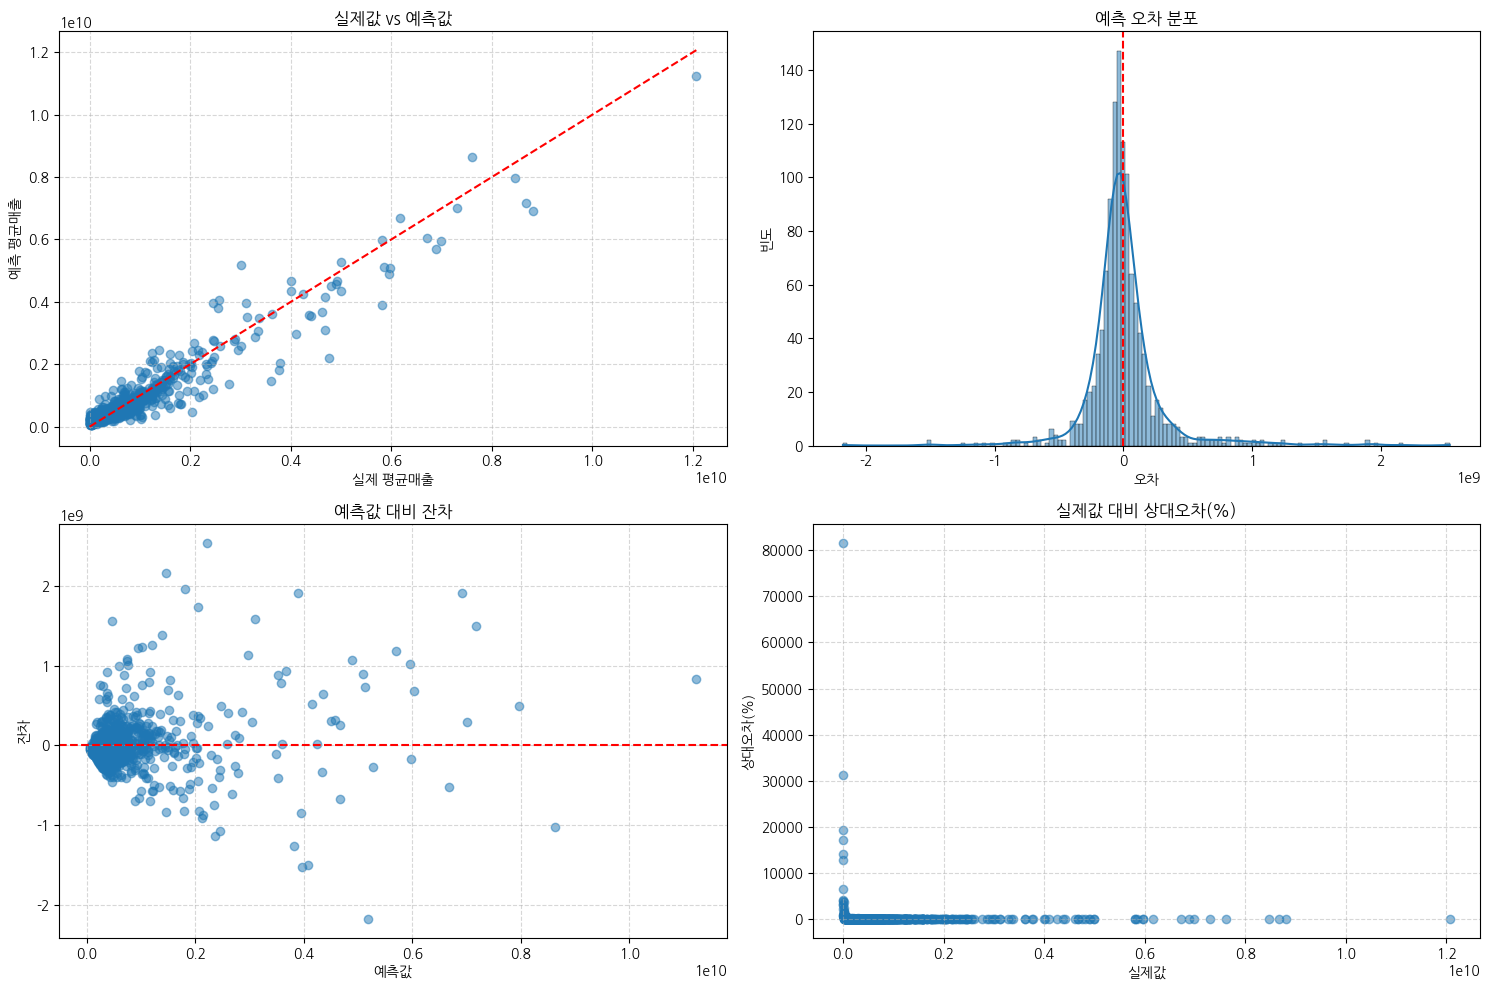

In [66]:
# 예측 결과 시각화
plt.figure(figsize=(15, 10))

# 예측값 vs 실제값 산점도
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_final, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('실제값 vs 예측값')
plt.xlabel('실제 평균매출')
plt.ylabel('예측 평균매출')
plt.grid(True, linestyle='--', alpha=0.5)

# 잔차 히스토그램
plt.subplot(2, 2, 2)
sns.histplot(prediction_df['오차'], kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('예측 오차 분포')
plt.xlabel('오차')
plt.ylabel('빈도')

# 예측값 대비 잔차 산점도
plt.subplot(2, 2, 3)
plt.scatter(y_pred_final, prediction_df['오차'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('예측값 대비 잔차')
plt.xlabel('예측값')
plt.ylabel('잔차')
plt.grid(True, linestyle='--', alpha=0.5)

# 실제값 대비 상대오차 산점도
plt.subplot(2, 2, 4)
plt.scatter(y_test, prediction_df['상대오차(%)'], alpha=0.5)
plt.title('실제값 대비 상대오차(%)')
plt.xlabel('실제값')
plt.ylabel('상대오차(%)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 8. 예측 결과 및 결론

### 8.1 요식업 매출 예측 모델 결론

분석 결과, 최적화된 RandomForest 모델이 가장 우수한 성능을 보여주며, 특성 중요도 분석을 통해 매출 예측에 중요한 변수들을 확인할 수 있었습니다. 예측 결과 분석에서는 평균 절대 오차와 상대 오차가 합리적인 수준으로 나타났습니다. 이 모델은 새로운 상권의 예상 매출을 예측하는 데 활용할 수 있을 것입니다.

In [67]:
# 모델 결론 출력
print("\n최종 모델 성능 요약:")

# 특성 중요도 정보가 있는 경우에만 출력
if not importance_df.empty:
    top_features_str = ", ".join([f"{row['feature']}" for _, row in importance_df.head(5).iterrows()])
    print(f"모델: {final_model_name} (R²={test_r2:.4f})")
    print(f"상위 5개 중요 특성: {top_features_str}")
else:
    print(f"모델: {final_model_name} (R²={test_r2:.4f})")

print(f"평균 절대 오차: {prediction_df['절대오차'].mean():.2f}원")
print(f"평균 상대 오차: {prediction_df['상대오차(%)'].mean():.2f}%")


최종 모델 성능 요약:
모델: 최적화된 RandomForest (R²=0.9146)
상위 5개 중요 특성: 여성_직장_인구_수, 중년_유동인구_수, 상권_구분_코드_명_발달상권, 초년_직장_인구_수, 초년_유동인구_수
평균 절대 오차: 168971293.44원
평균 상대 오차: 242.80%


### 8.2 새로운 상권 예측 예시

In [68]:
# 새로운 상권 예측 예시
print("\n새로운 상권 매출 예측 예시:")
# 테스트 데이터의 첫 번째 샘플을 예시로 사용
sample_data = X_test.iloc[0:1].copy()
sample_prediction = final_model.predict(sample_data)[0]
actual_value = y_test.iloc[0]

print(f"샘플 상권 정보:")
for col in categorical_features:
    if col in sample_data.columns:
        print(f"- {col}: {sample_data[col].values[0]}")
        
for col in numeric_features[:3]:  # 주요 특성 3개만 표시
    if col in sample_data.columns:
        print(f"- {col}: {sample_data[col].values[0]:,.2f}")

print(f"\n예측 평균 매출: {sample_prediction:,.2f}원")
print(f"실제 평균 매출: {actual_value:,.2f}원")
print(f"예측 오차: {abs(actual_value - sample_prediction):,.2f}원 ({abs(actual_value - sample_prediction) / actual_value * 100:.2f}%)")


새로운 상권 매출 예측 예시:
샘플 상권 정보:
- 상권_구분_코드_명: 골목상권
- 기준_년분기_코드: 20244
- 총_유동인구_수: 20.00
- 남성_유동인구_수: 16.00
- 여성_유동인구_수: 4.00

예측 평균 매출: 277,321,720.74원
실제 평균 매출: 30,805,428.00원
예측 오차: 246,516,292.74원 (800.24%)


### 8.3 모델 및 데이터 저장

In [69]:
# 모델 저장
model_filename = f'models/{final_model_name.replace(" ", "_").lower()}_model.pkl'
joblib.dump(final_model, model_filename)
print(f"\n최종 모델 저장 완료: {model_filename}")

# 최종 정제된 데이터 저장
restaurant_data.to_csv("data/서울시_요식업_정제데이터.csv", index=False, encoding="cp949")
print("정제된 데이터 저장 완료: data/서울시_요식업_정제데이터.csv")


최종 모델 저장 완료: models/최적화된_randomforest_model.pkl
정제된 데이터 저장 완료: data/서울시_요식업_정제데이터.csv
